In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
df_Collisions_Crashes=pd.read_csv('data/Motor_Vehicle_Collisions_Crashes.csv')

df_Collisions_Crashes.head()

CRASH DATE CRASH TIME   BOROUGH ZIP CODE  LATITUDE  LONGITUDE  \
0  09/11/2021       2:39       NaN      NaN       NaN        NaN   
1  03/26/2022      11:45       NaN      NaN       NaN        NaN   
2  11/01/2023       1:29  BROOKLYN  11230.0  40.62179 -73.970024   
3  06/29/2022       6:55       NaN      NaN       NaN        NaN   
4  09/21/2022      13:21       NaN      NaN       NaN        NaN   

                     LOCATION           ON STREET NAME CROSS STREET NAME  \
0                         NaN    WHITESTONE EXPRESSWAY         20 AVENUE   
1                         NaN  QUEENSBORO BRIDGE UPPER               NaN   
2      (40.62179, -73.970024)            OCEAN PARKWAY          AVENUE K   
3                         NaN       THROGS NECK BRIDGE               NaN   
4                         NaN          BROOKLYN BRIDGE               NaN   

  OFF STREET NAME  ...  CONTRIBUTING FACTOR VEHICLE 2  \
0             NaN  ...                    Unspecified   
1             NaN  ...                            NaN   
2             NaN  ...                    Unspecified   
3             NaN  ...                    Unspecified   
4             NaN  ...                    Unspecified   

   CONTRIBUTING FACTOR VEHICLE 3  CONTRIBUTING FACTOR VEHICLE 4  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                    Unspecified                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

   CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
0                            NaN       4455765   
1                            NaN       4513547   
2                            NaN       4675373   
3                            NaN       4541903   
4                            NaN       4566131   

                   VEHICLE TYPE CODE 1  VEHICLE TYPE CODE 2  \
0                                Sedan                Sedan   
1                                Sedan                  NaN   
2                                Moped                Sedan   
3                                Sedan        Pick-up Truck   
4  Station Wagon/Sport Utility Vehicle                  NaN   

   VEHICLE TYPE CODE 3 VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5  
0                  NaN                 NaN                 NaN  
1                  NaN                 NaN                 NaN  
2                Sedan                 NaN                 NaN  
3                  NaN                 NaN                 NaN  
4                  NaN                 NaN                 NaN  

[5 rows x 29 columns]

Time series: collisions per day / month to show trends.

<Axes: title={'center': 'Monthly Collisions'}, xlabel='CRASH DATE'>

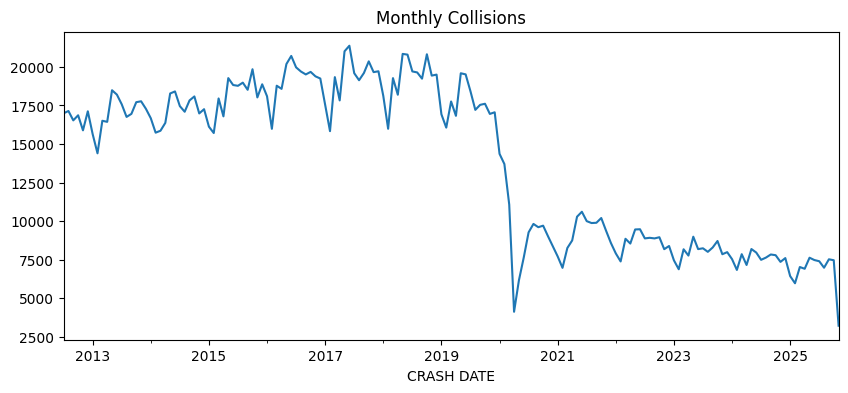

In [3]:
df = df_Collisions_Crashes.copy()
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')
ts = df.set_index('CRASH DATE').resample('M').size()
ts.plot(title='Monthly Collisions', figsize=(10,4))

Hour-of-day vs day-of-week heatmap: find peak danger times.

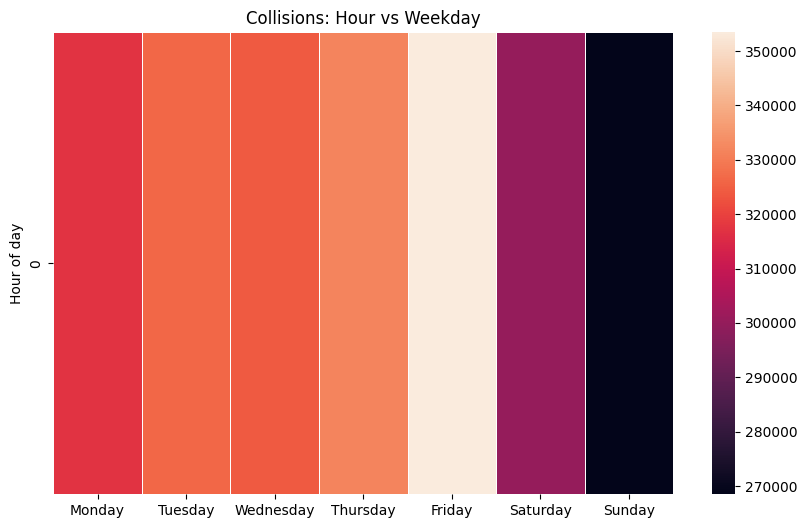

In [4]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')
df = df.dropna(subset=['CRASH DATE']).copy()
df['hour'] = df['CRASH DATE'].dt.hour
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['weekday'] = pd.Categorical(df['CRASH DATE'].dt.day_name(), categories=weekday_order, ordered=True)
pivot = df.groupby(['hour','weekday']).size().unstack(fill_value=0).reindex(columns=weekday_order).fillna(0)
plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='rocket', linewidths=.5)
plt.title('Collisions: Hour vs Weekday')
plt.ylabel('Hour of day')
plt.xlabel('')
plt.show()

Map scatter (lat/lon): spatial density of collisions (cluster or heatmap).

In [5]:
import plotly.express as px
m = df_Collisions_Crashes.dropna(subset=['LATITUDE','LONGITUDE']).sample(n=min(20000, len(df_Collisions_Crashes)))
fig = px.scatter_mapbox(m, lat='LATITUDE', lon='LONGITUDE', color='BOROUGH',
                        hover_data=['CRASH DATE','CONTRIBUTING FACTOR VEHICLE 1'],
                        zoom=10, height=600)
fig.update_layout(mapbox_style='open-street-map')
fig.show()


Choropleth by borough or zip: collisions per area (requires geo boundaries).

# Injuries/Fatalities by Borough (Stacked Bar)

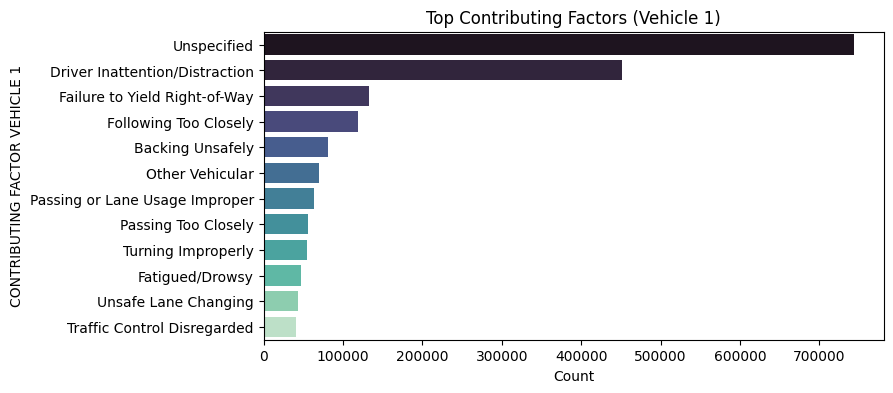

In [6]:
top = df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(12)
plt.figure(figsize=(8,4))
sns.barplot(x=top.values, y=top.index, palette='mako')
plt.title('Top Contributing Factors (Vehicle 1)')
plt.xlabel('Count')
plt.show()

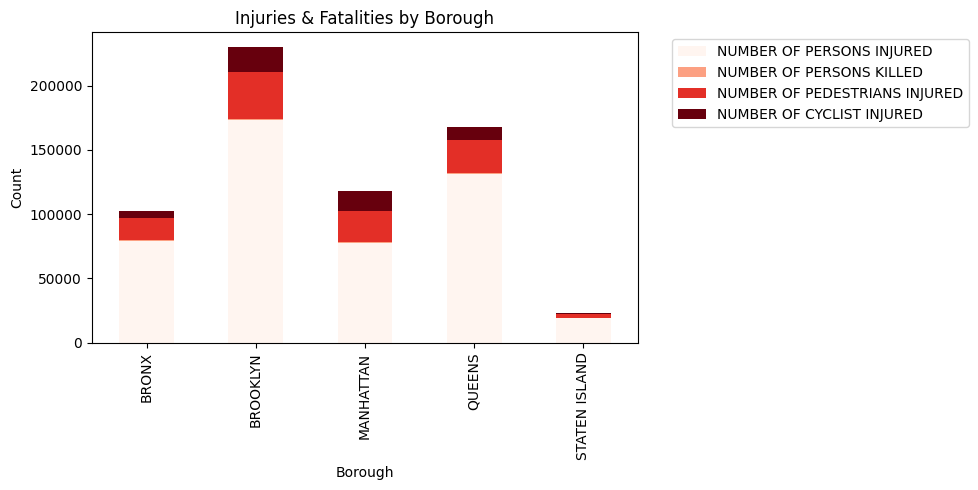

In [7]:
injury_cols = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
               'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED']
borough_injuries = df_Collisions_Crashes.groupby('BOROUGH')[injury_cols].sum().fillna(0)
borough_injuries.plot(kind='bar', stacked=True, figsize=(10,5), colormap='Reds')
plt.title('Injuries & Fatalities by Borough')
plt.ylabel('Count')
plt.xlabel('Borough')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

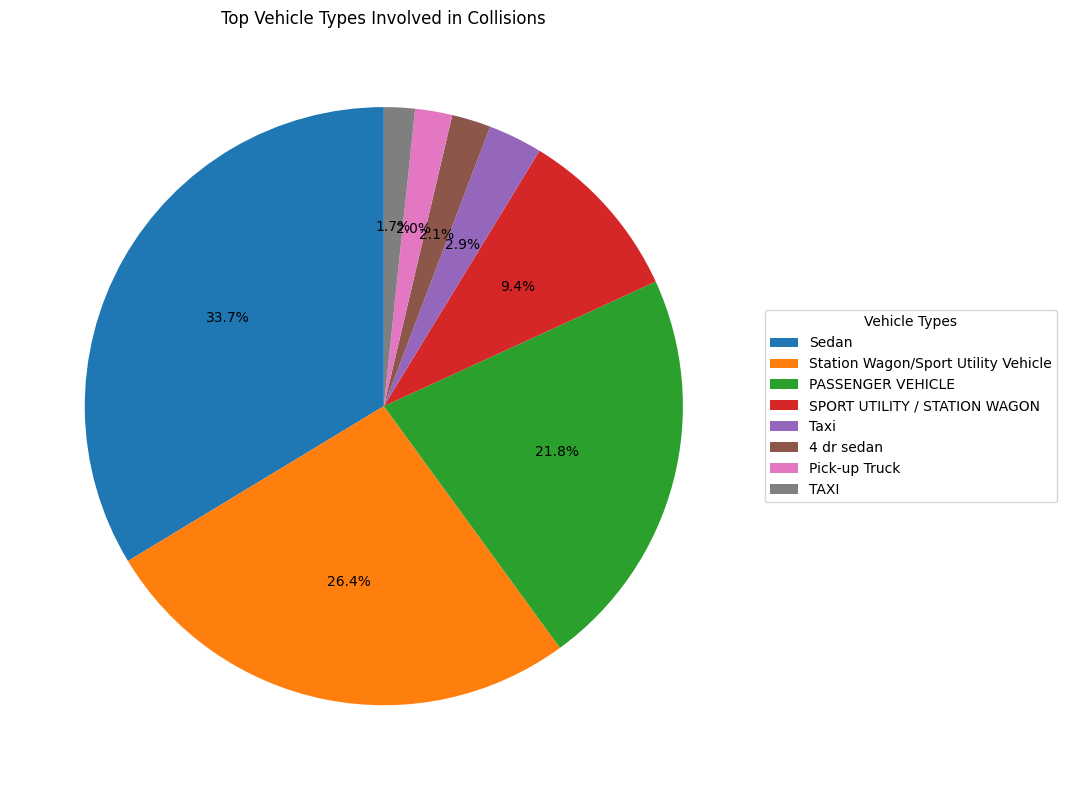

In [8]:
# ...existing code...
vehicle_types = df_Collisions_Crashes['VEHICLE TYPE CODE 1'].value_counts().head(8)
plt.figure(figsize=(10,8))
wedges, texts, autotexts = plt.pie(vehicle_types.values, autopct='%1.1f%%', startangle=90)
plt.title('Top Vehicle Types Involved in Collisions')
plt.legend(wedges, vehicle_types.index, title="Vehicle Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()
# ...existing code...

# Contributing Factor vs Injuries (Scatter/Box Plot)

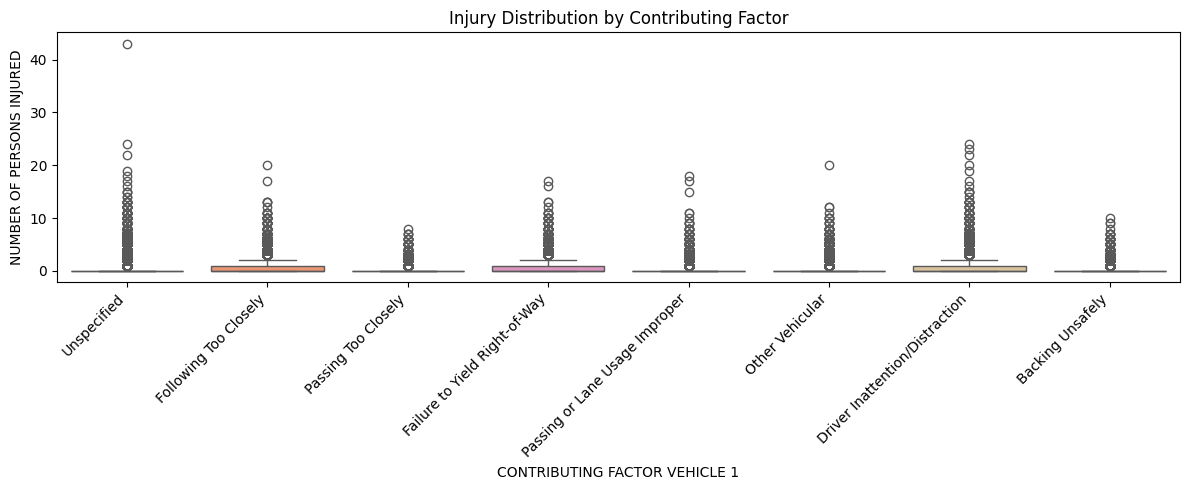

In [9]:
df_clean = df_Collisions_Crashes[df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].notna()].copy()
top_factors = df_clean['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(8).index
df_factors = df_clean[df_clean['CONTRIBUTING FACTOR VEHICLE 1'].isin(top_factors)]
plt.figure(figsize=(12,5))
sns.boxplot(data=df_factors, x='CONTRIBUTING FACTOR VEHICLE 1', y='NUMBER OF PERSONS INJURED', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Injury Distribution by Contributing Factor')
plt.tight_layout()
plt.show()

# Time of Day vs Severity (Stacked Area)

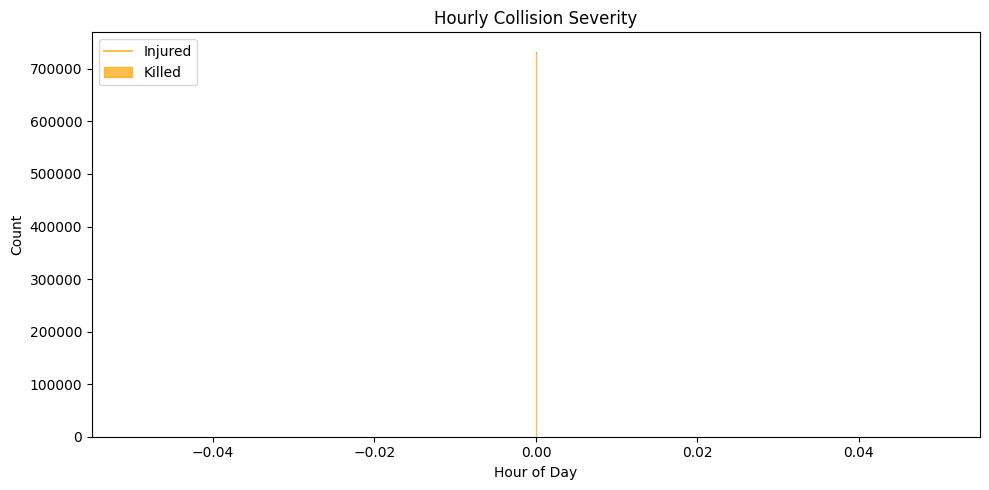

In [10]:
# 4. Time of Day vs Severity (Stacked Area)
df_time = df_Collisions_Crashes.copy()
df_time['CRASH DATE'] = pd.to_datetime(df_time['CRASH DATE'], errors='coerce')
df_time = df_time.dropna(subset=['CRASH DATE'])  # Added: drop rows with invalid dates
df_time['hour'] = df_time['CRASH DATE'].dt.hour
severity = df_time.groupby('hour')[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sum()
severity.plot(kind='area', stacked=True, figsize=(10,5), alpha=0.7, color=['orange','red'])
plt.title('Hourly Collision Severity')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(['Injured', 'Killed'], loc='upper left')  # Added loc parameter for better placement
plt.tight_layout()  # Added for better layout
plt.show()

# Correlation Heatmap (Numeric Features)

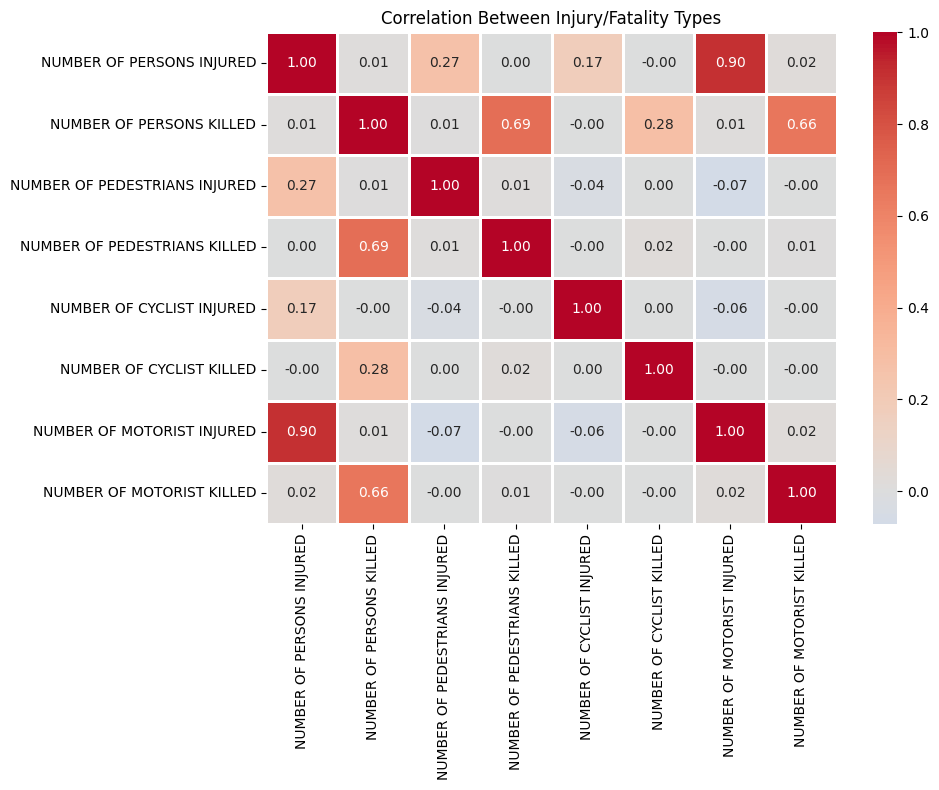

In [11]:
numeric_cols = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
                'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
                'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']
corr = df_Collisions_Crashes[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=1)
plt.title('Correlation Between Injury/Fatality Types')
plt.tight_layout()
plt.show()

# Borough vs Contributing Factor (Grouped Bar)

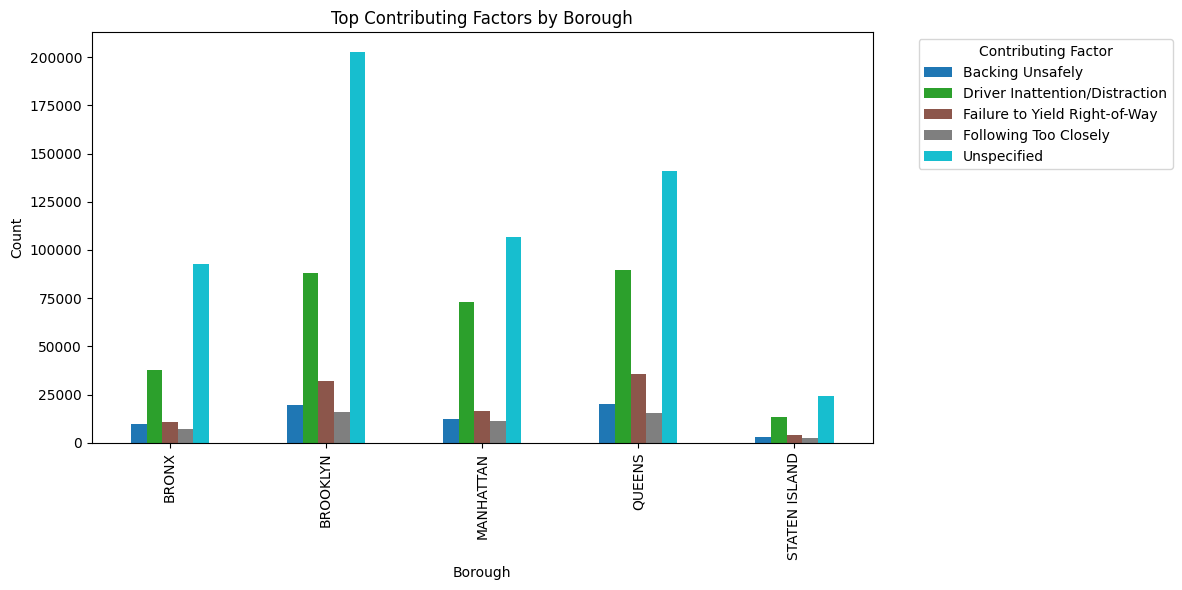

In [12]:
top_boroughs = df_Collisions_Crashes['BOROUGH'].value_counts().head(5).index
top_5_factors = df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(5).index
df_cross = df_Collisions_Crashes[(df_Collisions_Crashes['BOROUGH'].isin(top_boroughs)) & 
                                  (df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].isin(top_5_factors))]
cross_tab = pd.crosstab(df_cross['BOROUGH'], df_cross['CONTRIBUTING FACTOR VEHICLE 1'])
cross_tab.plot(kind='bar', figsize=(12,6), colormap='tab10')
plt.title('Top Contributing Factors by Borough')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.legend(title='Contributing Factor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Interactive Time Series with Plotly (Daily Collisions)

In [13]:
df_daily = df_Collisions_Crashes.copy()
df_daily['CRASH DATE'] = pd.to_datetime(df_daily['CRASH DATE'], errors='coerce')
daily_counts = df_daily.groupby(df_daily['CRASH DATE'].dt.date).size().reset_index(name='Count')
daily_counts.columns = ['Date', 'Collisions']
fig = px.line(daily_counts, x='Date', y='Collisions', title='Daily Collision Trend')
fig.update_traces(line_color='steelblue')
fig.show()

# Violin Plot: Injuries by Day of Week

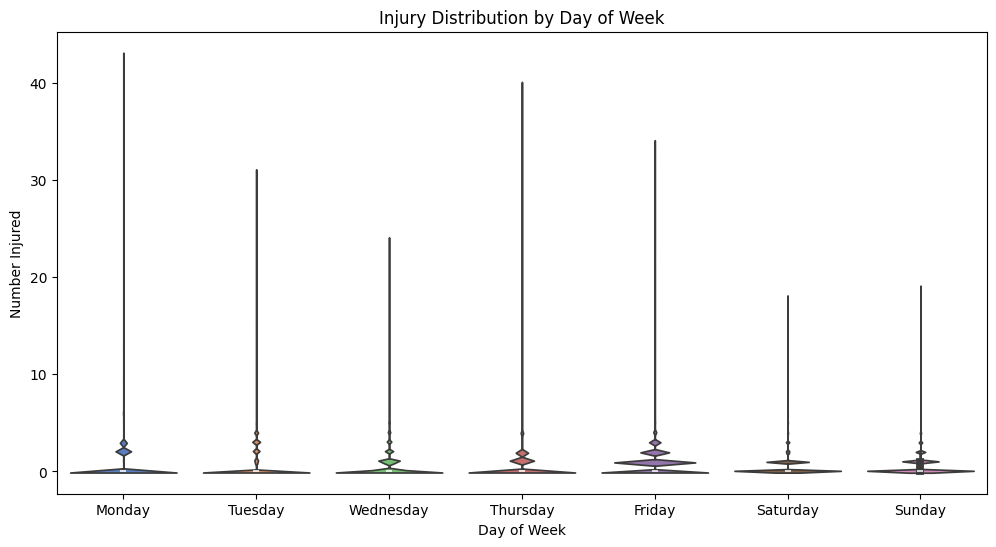

In [14]:
df_violin = df_Collisions_Crashes.copy()
df_violin['CRASH DATE'] = pd.to_datetime(df_violin['CRASH DATE'], errors='coerce')
df_violin = df_violin.dropna(subset=['CRASH DATE'])
df_violin['weekday'] = df_violin['CRASH DATE'].dt.day_name()
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(12,6))
sns.violinplot(data=df_violin, x='weekday', y='NUMBER OF PERSONS INJURED', 
               order=weekday_order, palette='muted')
plt.title('Injury Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number Injured')
plt.show()

# Street Name Analysis - Top Dangerous Streets

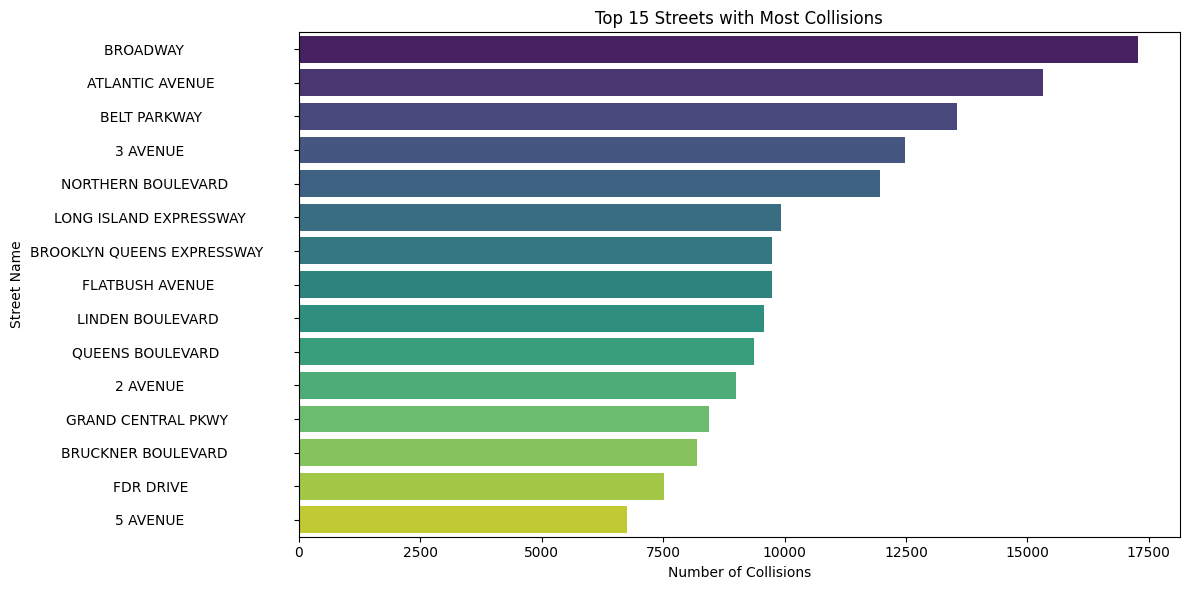

In [15]:
top_streets = df_Collisions_Crashes['ON STREET NAME'].value_counts().head(15)
plt.figure(figsize=(12,6))
sns.barplot(x=top_streets.values, y=top_streets.index, palette='viridis')
plt.title('Top 15 Streets with Most Collisions')
plt.xlabel('Number of Collisions')
plt.ylabel('Street Name')
plt.tight_layout()
plt.show()

# Monthly Trend by Borough (Line Chart)

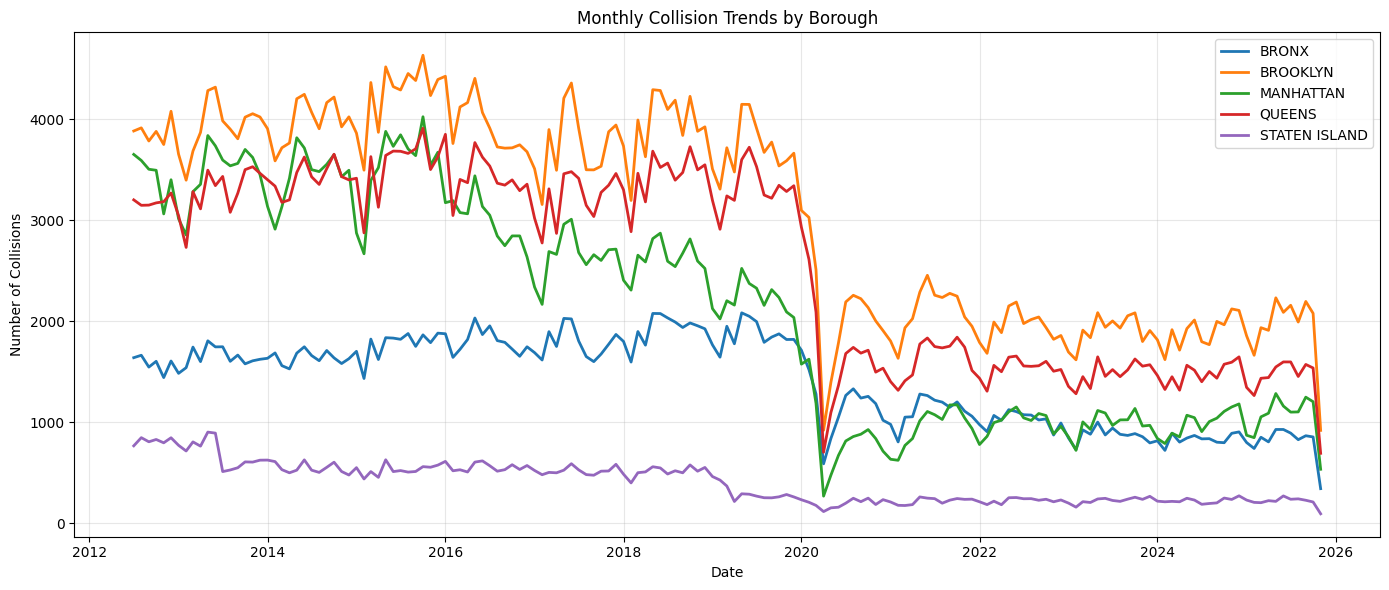

In [16]:
df_borough_time = df_Collisions_Crashes.copy()
df_borough_time['CRASH DATE'] = pd.to_datetime(df_borough_time['CRASH DATE'], errors='coerce')
df_borough_time = df_borough_time.dropna(subset=['CRASH DATE', 'BOROUGH'])
df_borough_time['month'] = df_borough_time['CRASH DATE'].dt.to_period('M')
monthly_borough = df_borough_time.groupby(['month', 'BOROUGH']).size().unstack(fill_value=0)
monthly_borough.index = monthly_borough.index.to_timestamp()
plt.figure(figsize=(14,6))
for col in monthly_borough.columns:
    plt.plot(monthly_borough.index, monthly_borough[col], label=col, linewidth=2)
plt.title('Monthly Collision Trends by Borough')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Injury Severity Funnel Chart

In [17]:
severity_data = pd.DataFrame({
    'Category': ['Total Collisions', 'With Injuries', 'With Deaths'],
    'Count': [
        len(df_Collisions_Crashes),
        df_Collisions_Crashes[df_Collisions_Crashes['NUMBER OF PERSONS INJURED'] > 0].shape[0],
        df_Collisions_Crashes[df_Collisions_Crashes['NUMBER OF PERSONS KILLED'] > 0].shape[0]
    ]
})
fig = px.funnel(severity_data, x='Count', y='Category', title='Collision Severity Funnel')
fig.show()

# Contributing Factor Word Cloud (Top 30)

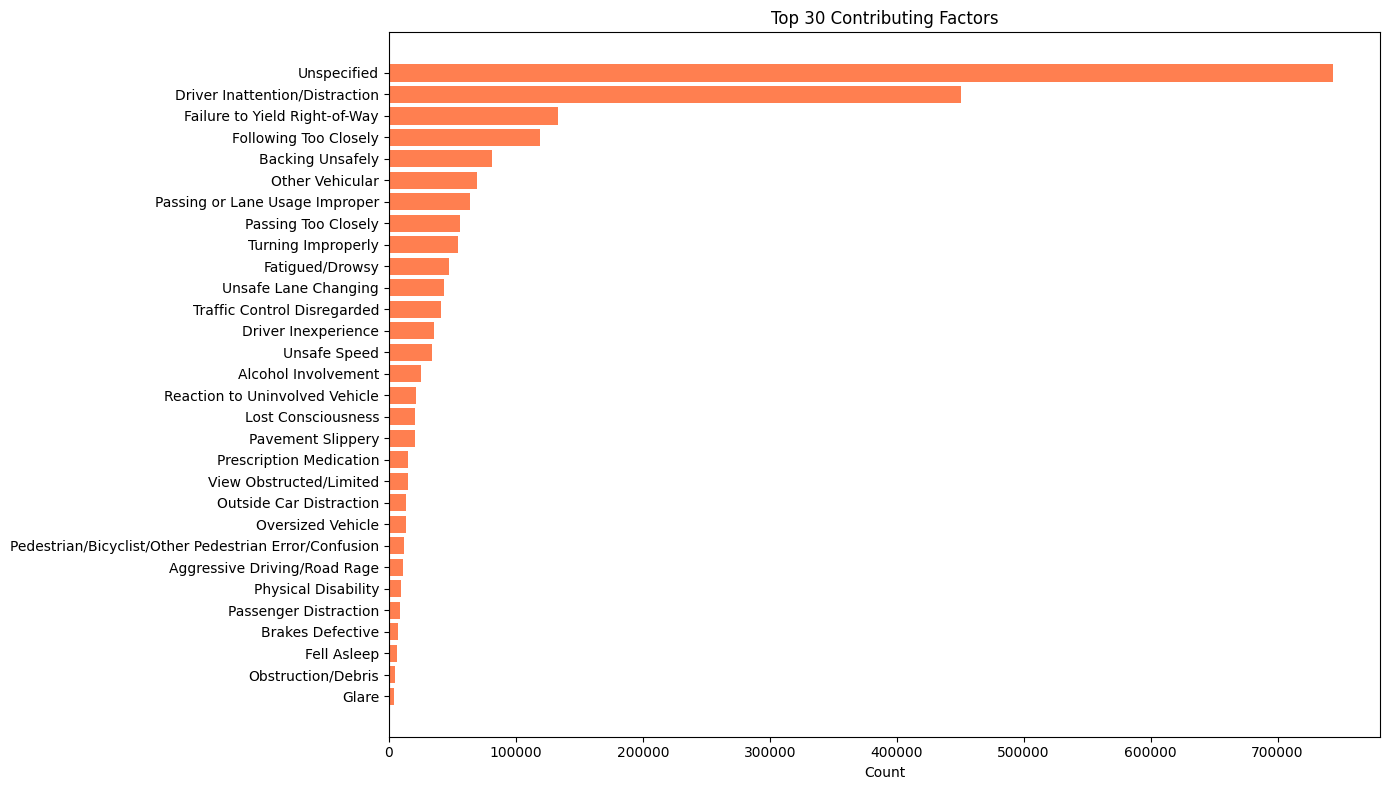

In [18]:
from collections import Counter
factors = df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].dropna()
factor_counts = Counter(factors)
top_30 = dict(factor_counts.most_common(30))
plt.figure(figsize=(14,8))
plt.barh(list(top_30.keys())[::-1], list(top_30.values())[::-1], color='coral')
plt.title('Top 30 Contributing Factors')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# Zip Code Heatmap (Top 20 Zip Codes)

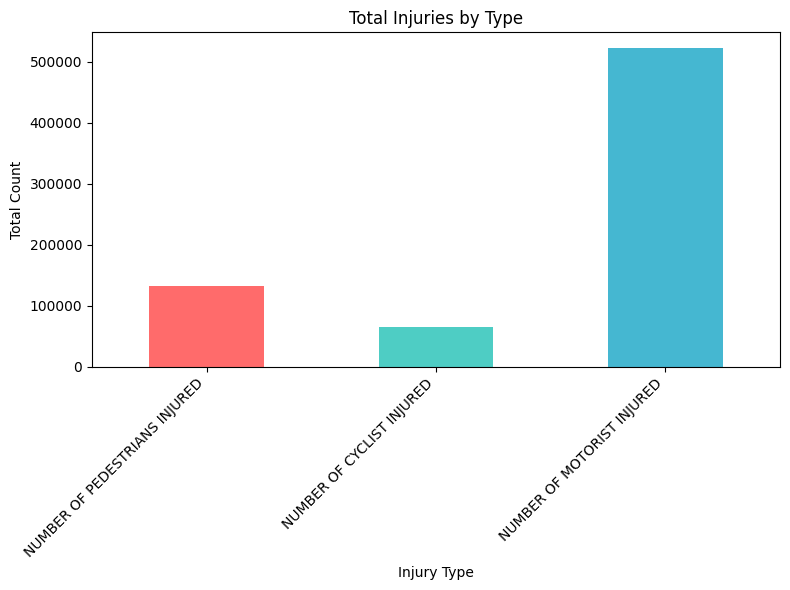

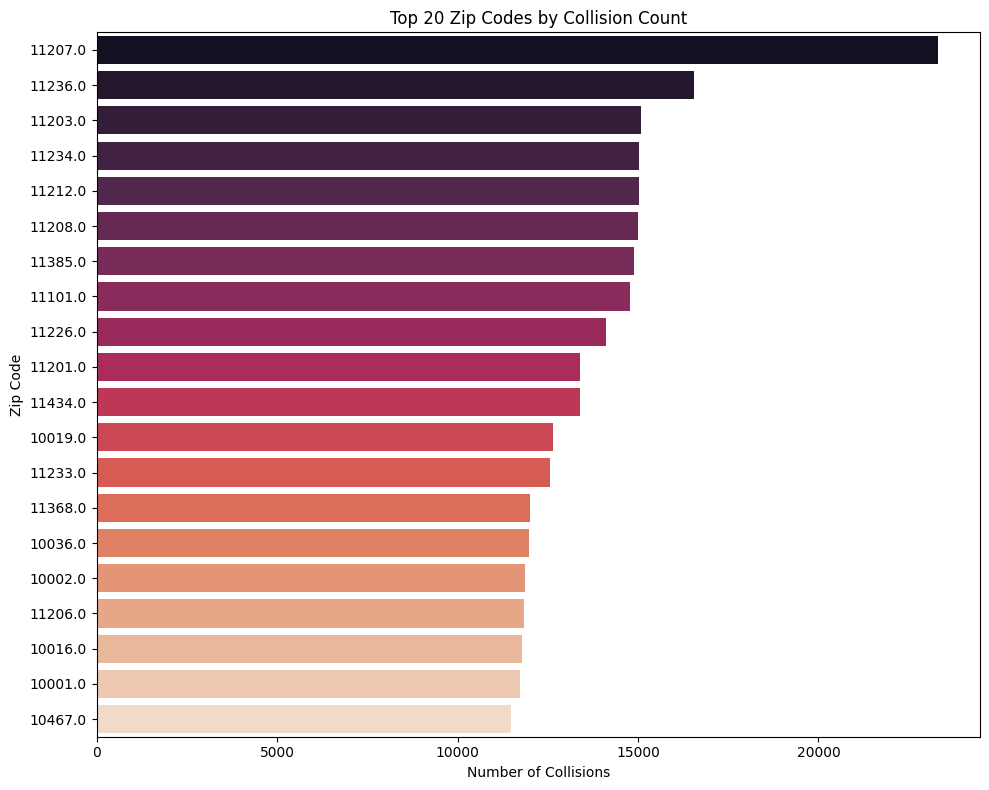

In [19]:
injury_comparison = df_Collisions_Crashes[['NUMBER OF PEDESTRIANS INJURED', 
                                             'NUMBER OF CYCLIST INJURED', 
                                             'NUMBER OF MOTORIST INJURED']].sum()
plt.figure(figsize=(8,6))
injury_comparison.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Total Injuries by Type')
plt.xlabel('Injury Type')
plt.ylabel('Total Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 14. Zip Code Heatmap (Top 20 Zip Codes)
zip_collisions = df_Collisions_Crashes['ZIP CODE'].value_counts().head(20)
plt.figure(figsize=(10,8))
sns.barplot(y=zip_collisions.index.astype(str), x=zip_collisions.values, palette='rocket')
plt.title('Top 20 Zip Codes by Collision Count')
plt.xlabel('Number of Collisions')
plt.ylabel('Zip Code')
plt.tight_layout()
plt.show()

# Multi-Vehicle Involvement Analysis

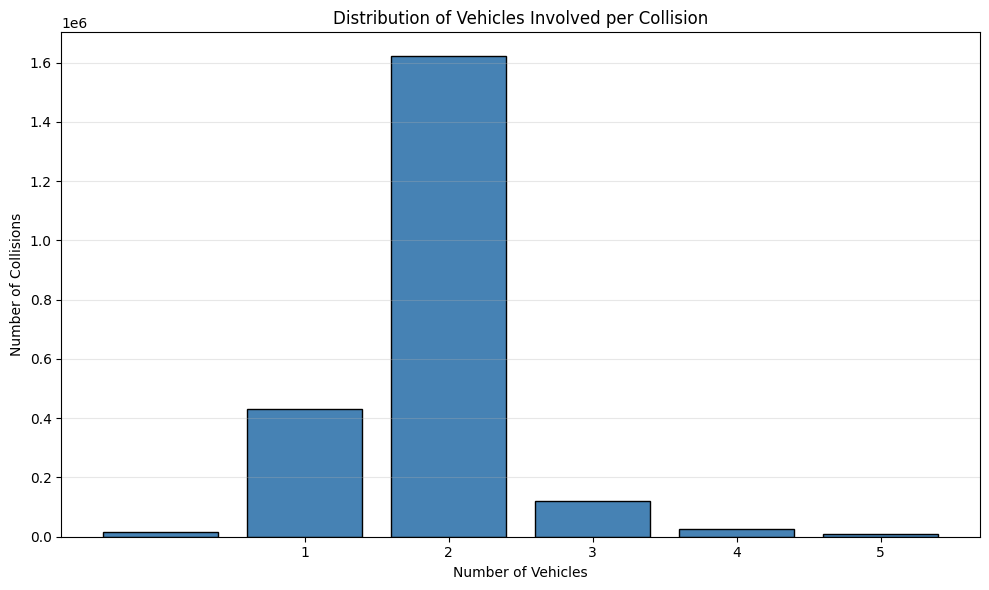

In [20]:
df_Collisions_Crashes['vehicle_count'] = df_Collisions_Crashes[['VEHICLE TYPE CODE 1', 
                                                                   'VEHICLE TYPE CODE 2', 
                                                                   'VEHICLE TYPE CODE 3', 
                                                                   'VEHICLE TYPE CODE 4', 
                                                                   'VEHICLE TYPE CODE 5']].notna().sum(axis=1)
vehicle_dist = df_Collisions_Crashes['vehicle_count'].value_counts().sort_index()
plt.figure(figsize=(10,6))
plt.bar(vehicle_dist.index, vehicle_dist.values, color='steelblue', edgecolor='black')
plt.title('Distribution of Vehicles Involved per Collision')
plt.xlabel('Number of Vehicles')
plt.ylabel('Number of Collisions')
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Fatality Rate by Borough (Percentage)

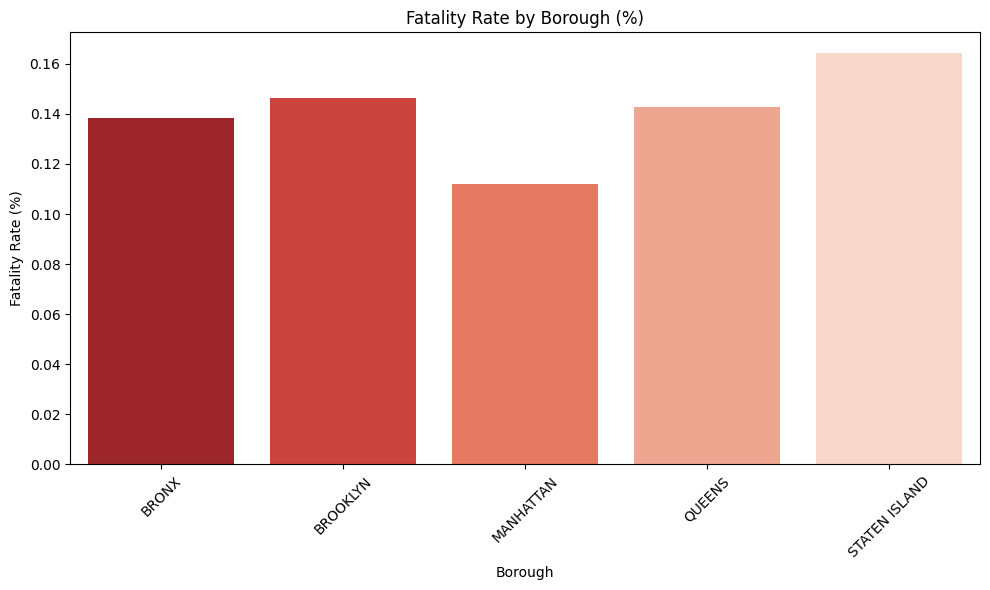

In [21]:
borough_stats = df_Collisions_Crashes.groupby('BOROUGH').agg({
    'NUMBER OF PERSONS KILLED': 'sum',
    'COLLISION_ID': 'count'
}).rename(columns={'COLLISION_ID': 'total_collisions'})
borough_stats['fatality_rate'] = (borough_stats['NUMBER OF PERSONS KILLED'] / 
                                    borough_stats['total_collisions'] * 100)
plt.figure(figsize=(10,6))
sns.barplot(x=borough_stats.index, y=borough_stats['fatality_rate'], palette='Reds_r')
plt.title('Fatality Rate by Borough (%)')
plt.xlabel('Borough')
plt.ylabel('Fatality Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Year-over-Year Comparison

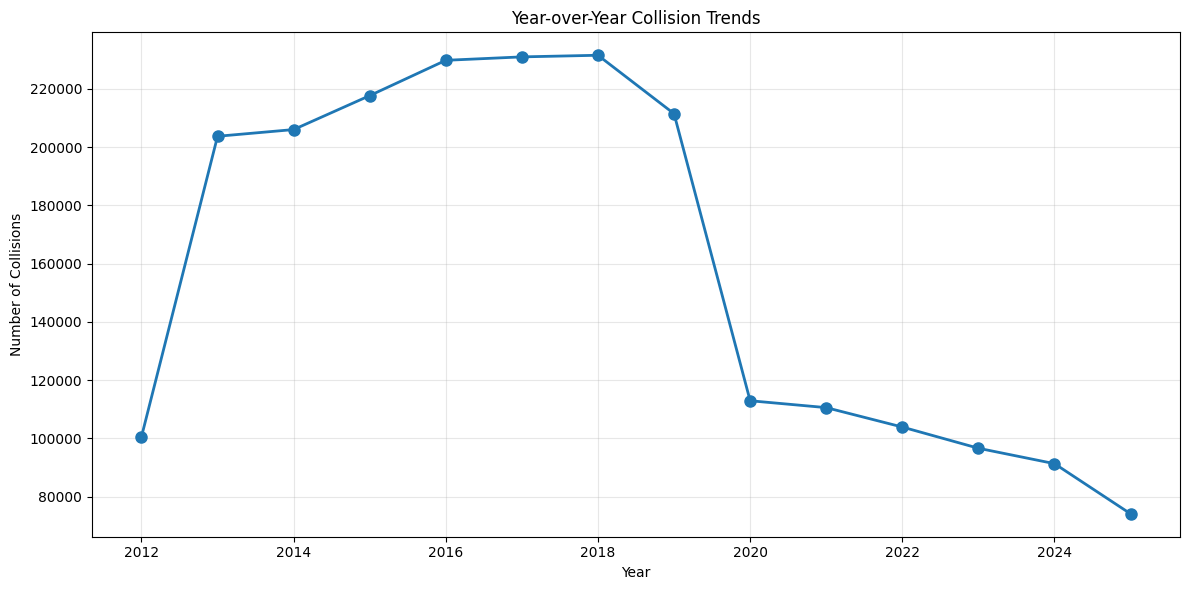

In [22]:
df_yoy = df_Collisions_Crashes.copy()
df_yoy['CRASH DATE'] = pd.to_datetime(df_yoy['CRASH DATE'], errors='coerce')
df_yoy = df_yoy.dropna(subset=['CRASH DATE'])
df_yoy['year'] = df_yoy['CRASH DATE'].dt.year
yearly_counts = df_yoy.groupby('year').size()
plt.figure(figsize=(12,6))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=8)
plt.title('Year-over-Year Collision Trends')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

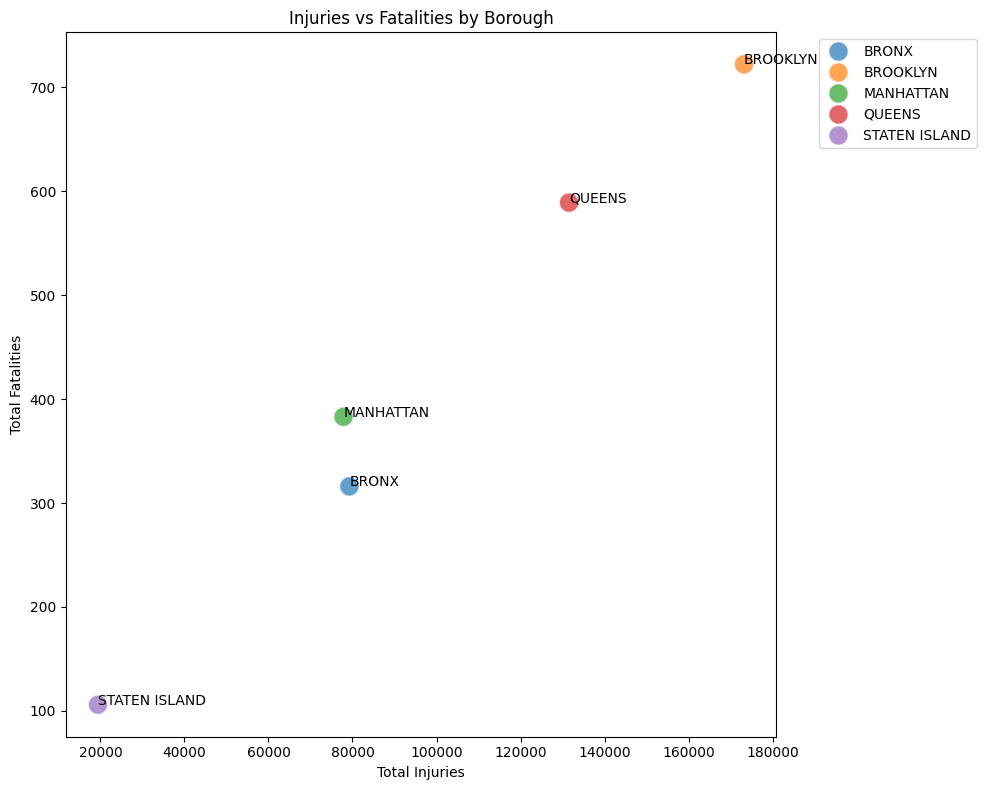

In [23]:
borough_scatter = df_Collisions_Crashes.groupby('BOROUGH').agg({
    'NUMBER OF PERSONS INJURED': 'sum',
    'NUMBER OF PERSONS KILLED': 'sum'
}).reset_index()
plt.figure(figsize=(10,8))
sns.scatterplot(data=borough_scatter, x='NUMBER OF PERSONS INJURED', 
                y='NUMBER OF PERSONS KILLED', hue='BOROUGH', s=200, alpha=0.7)
for i, row in borough_scatter.iterrows():
    plt.annotate(row['BOROUGH'], (row['NUMBER OF PERSONS INJURED'], 
                 row['NUMBER OF PERSONS KILLED']), fontsize=10)
plt.title('Injuries vs Fatalities by Borough')
plt.xlabel('Total Injuries')
plt.ylabel('Total Fatalities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

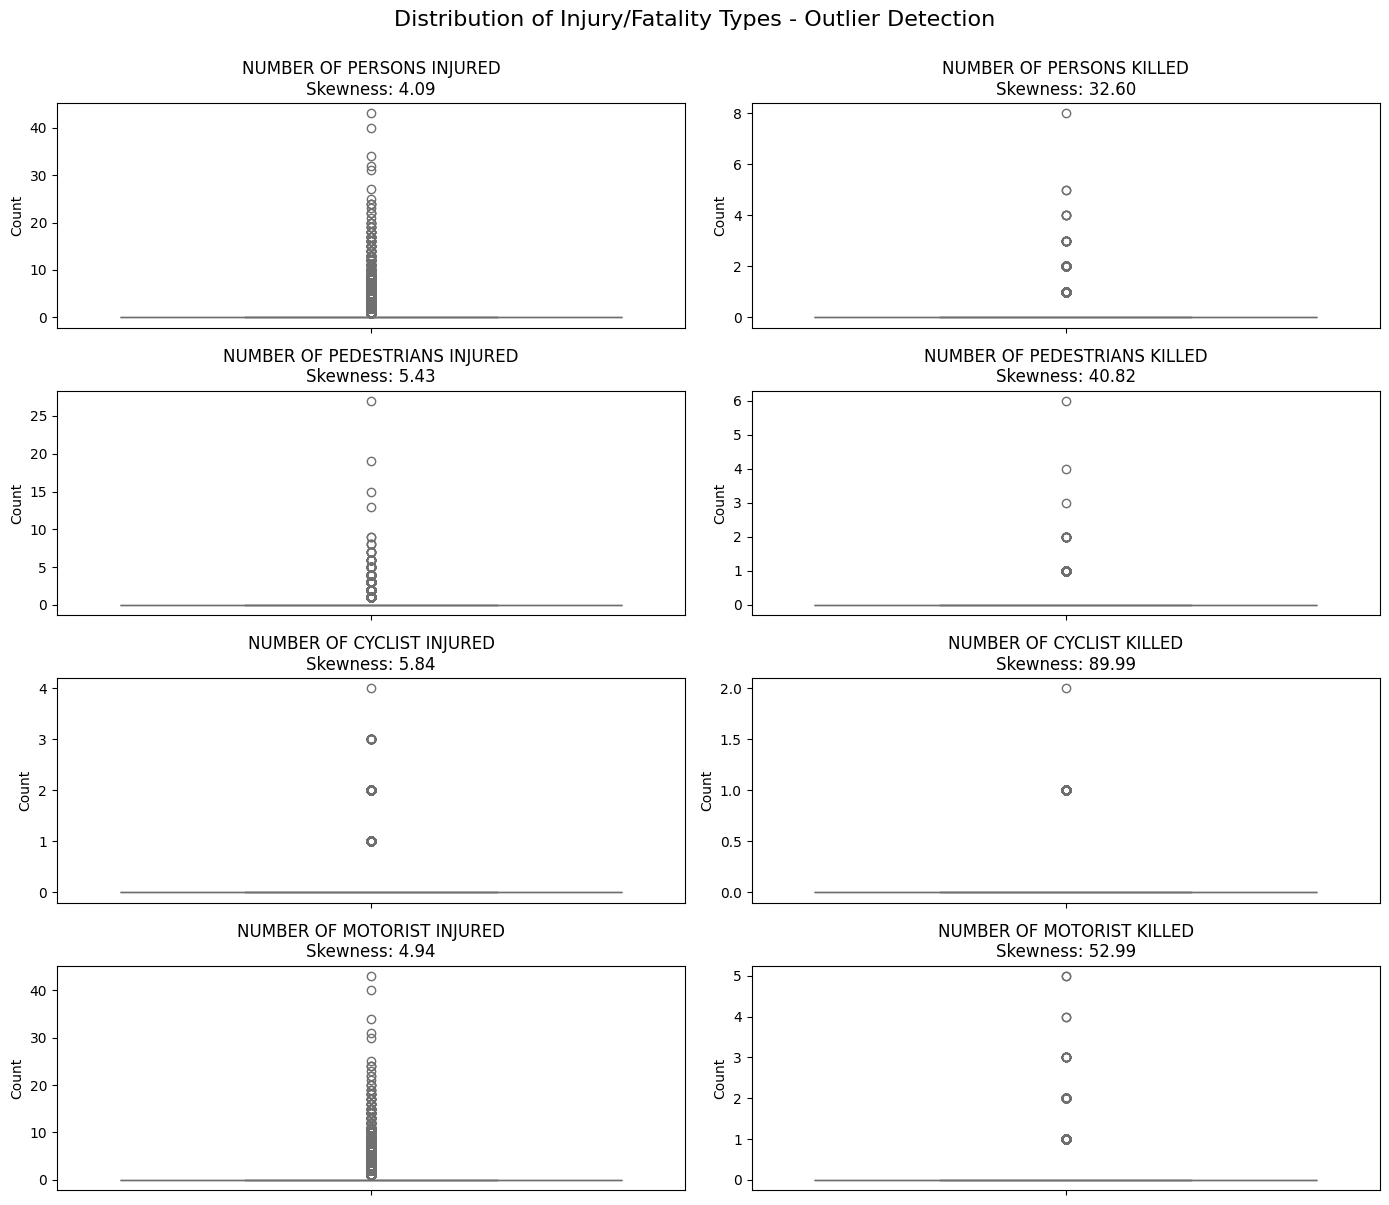

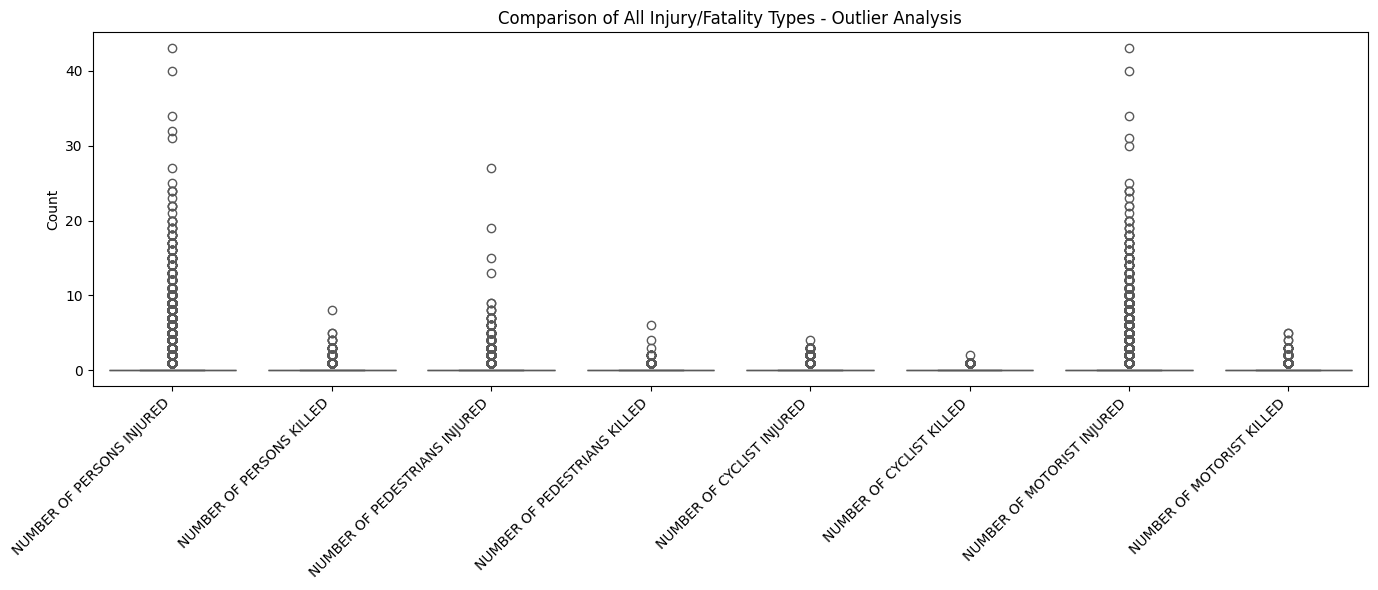

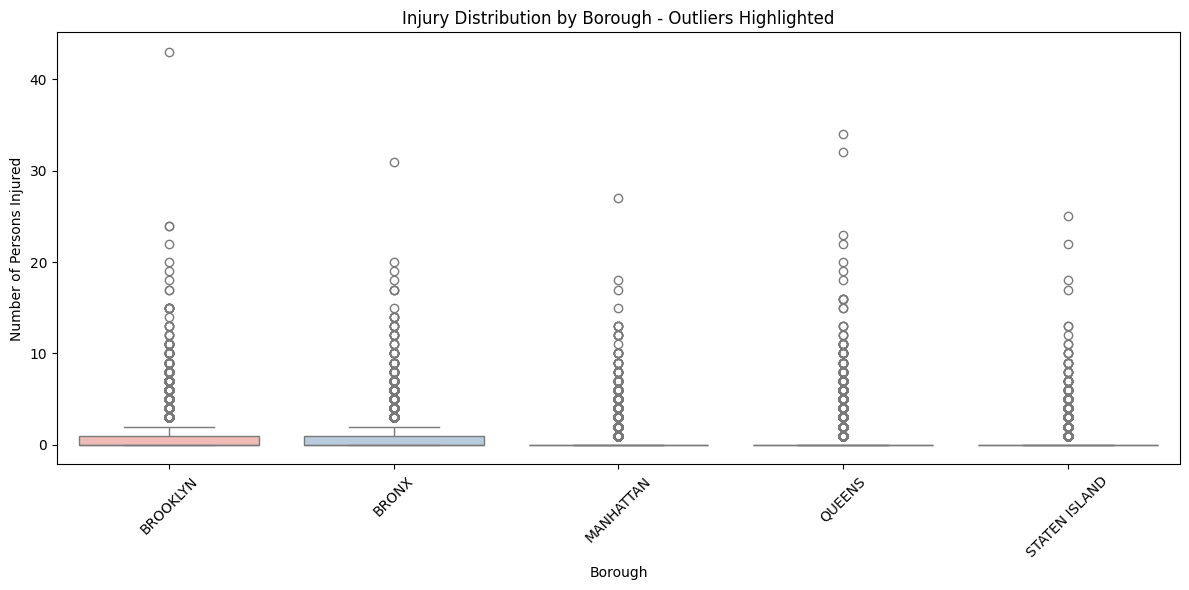

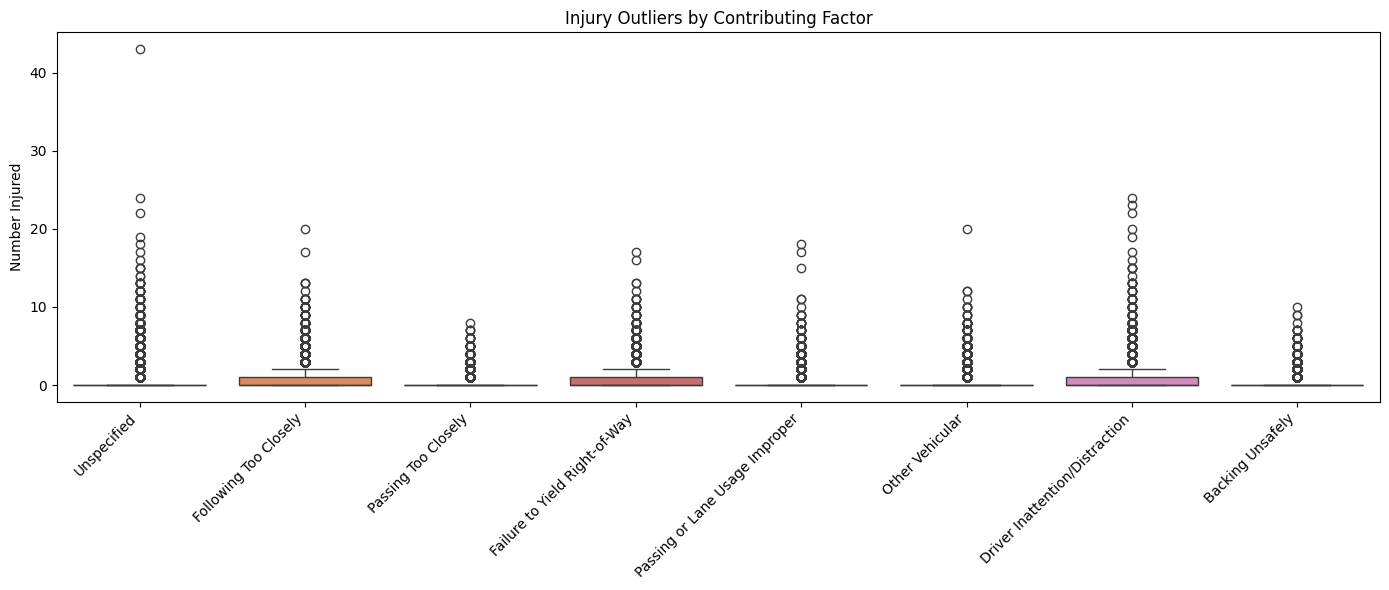


=== Outlier Analysis Summary ===
                       Column     Mean  Median  Std Dev  Skewness  Outliers  Outlier %
    NUMBER OF PERSONS INJURED 0.328355     0.0 0.714994  4.087288    538482  24.241739
     NUMBER OF PERSONS KILLED 0.001585     0.0 0.042054 32.597547      3373   0.151848
NUMBER OF PEDESTRIANS INJURED 0.059631     0.0 0.250123  5.426980    127001   5.717415
 NUMBER OF PEDESTRIANS KILLED 0.000784     0.0 0.028629 40.821000      1716   0.077252
    NUMBER OF CYCLIST INJURED 0.029203     0.0 0.170645  5.838939     64041   2.883040
     NUMBER OF CYCLIST KILLED 0.000126     0.0 0.011267 89.994498       279   0.012560
   NUMBER OF MOTORIST INJURED 0.234870     0.0 0.676135  4.939169    341154  15.358297
    NUMBER OF MOTORIST KILLED 0.000645     0.0 0.027771 52.985561      1322   0.059515


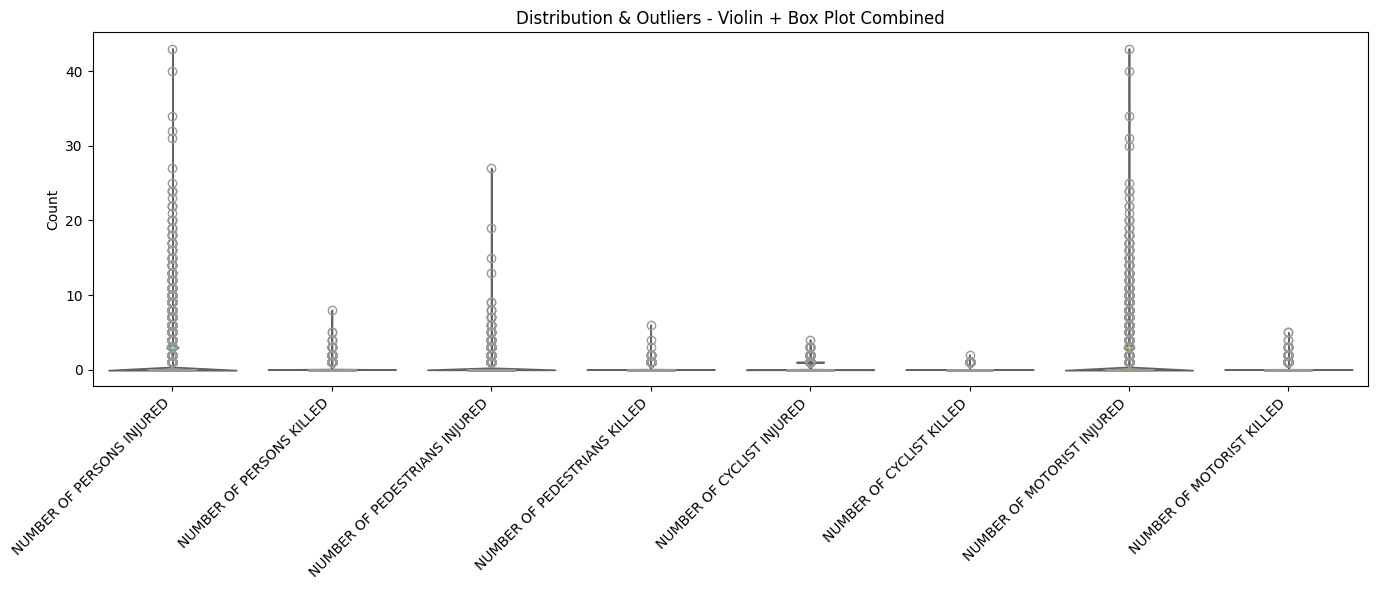

In [24]:
# Box Plots for Numerical Features - Show Skewness & Outliers

# 1. Individual Box Plots for Each Injury/Fatality Type
numeric_cols = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
                'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
                'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']

fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(data=df_Collisions_Crashes, y=col, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'{col}\nSkewness: {df_Collisions_Crashes[col].skew():.2f}')
    axes[idx].set_ylabel('Count')
    
plt.suptitle('Distribution of Injury/Fatality Types - Outlier Detection', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

# 2. Combined Box Plot - All Injury Types Side by Side
plt.figure(figsize=(14, 6))
df_melted = df_Collisions_Crashes[numeric_cols].melt(var_name='Injury Type', value_name='Count')
sns.boxplot(data=df_melted, x='Injury Type', y='Count', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Comparison of All Injury/Fatality Types - Outlier Analysis')
plt.ylabel('Count')
plt.xlabel('')
plt.tight_layout()
plt.show()

# 3. Box Plot by Borough - Injuries
plt.figure(figsize=(12, 6))
df_box = df_Collisions_Crashes.dropna(subset=['BOROUGH', 'NUMBER OF PERSONS INJURED'])
sns.boxplot(data=df_box, x='BOROUGH', y='NUMBER OF PERSONS INJURED', palette='Pastel1')
plt.title('Injury Distribution by Borough - Outliers Highlighted')
plt.xlabel('Borough')
plt.ylabel('Number of Persons Injured')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Box Plot by Contributing Factor (Top 8)
df_clean = df_Collisions_Crashes[df_Collisions_Crashes['CONTRIBUTING FACTOR VEHICLE 1'].notna()].copy()
top_factors = df_clean['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(8).index
df_factors = df_clean[df_clean['CONTRIBUTING FACTOR VEHICLE 1'].isin(top_factors)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_factors, x='CONTRIBUTING FACTOR VEHICLE 1', y='NUMBER OF PERSONS INJURED', palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title('Injury Outliers by Contributing Factor')
plt.xlabel('')
plt.ylabel('Number Injured')
plt.tight_layout()
plt.show()

# 5. Statistical Summary with Outlier Count
outlier_summary = []
for col in numeric_cols:
    Q1 = df_Collisions_Crashes[col].quantile(0.25)
    Q3 = df_Collisions_Crashes[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_Collisions_Crashes[(df_Collisions_Crashes[col] < lower_bound) | 
                                       (df_Collisions_Crashes[col] > upper_bound)][col].count()
    
    outlier_summary.append({
        'Column': col,
        'Mean': df_Collisions_Crashes[col].mean(),
        'Median': df_Collisions_Crashes[col].median(),
        'Std Dev': df_Collisions_Crashes[col].std(),
        'Skewness': df_Collisions_Crashes[col].skew(),
        'Outliers': outliers,
        'Outlier %': (outliers / len(df_Collisions_Crashes) * 100)
    })

outlier_df = pd.DataFrame(outlier_summary)
print("\n=== Outlier Analysis Summary ===")
print(outlier_df.to_string(index=False))

# 6. Violin Plot with Box Plot Overlay - Shows Distribution + Outliers
plt.figure(figsize=(14, 6))
sns.violinplot(data=df_melted, x='Injury Type', y='Count', palette='Set3', inner=None)
sns.boxplot(data=df_melted, x='Injury Type', y='Count', width=0.3, color='white', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution & Outliers - Violin + Box Plot Combined')
plt.ylabel('Count')
plt.xlabel('')
plt.tight_layout()
plt.show()

### --- DATA CLEANING NOTEBOOK ---
Run the cleaning cells below to produce cleaned CSV.


In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configure display settings
warnings.filterwarnings('ignore')

In [26]:
# File paths
crashes_file = r'data\Motor_Vehicle_Collisions_Crashes.csv'
persons_file = r'data\Motor_Vehicle_Collisions_Person.csv'

# Load sample from crashes dataset
crashes_sample = pd.read_csv(crashes_file, low_memory=False)
print(f"✓ Crashes sample loaded: {crashes_sample.shape}")

print("\n=== DATASET STRUCTURE OVERVIEW ===")
print(f"Crashes Dataset: {crashes_sample.shape[1]} columns")

✓ Crashes sample loaded: (2221301, 29)

=== DATASET STRUCTURE OVERVIEW ===
Crashes Dataset: 29 columns


## Dataset 1: Motor Vehicle Collisions - Crashes Analysis

In [27]:
# Display first few rows of each dataset
print("\n--- Crashes Sample ---")
print(crashes_sample.head().to_string())


--- Crashes Sample ---
   CRASH DATE CRASH TIME   BOROUGH ZIP CODE  LATITUDE  LONGITUDE                    LOCATION           ON STREET NAME CROSS STREET NAME OFF STREET NAME  NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  NUMBER OF MOTORIST KILLED CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID                  VEHICLE TYPE CODE 1 VEHICLE TYPE CODE 2 VEHICLE TYPE CODE 3 VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5
0  09/11/2021       2:39       NaN      NaN       NaN        NaN                         NaN    WHITESTONE EXPRESSWAY         20 AVENUE             NaN                        2.0                       0.0                              0                             0                          0                         0   

In [28]:
# Clear any previous output and create missing stats analysis
missing_stats = pd.DataFrame({
    'Column': crashes_sample.columns,
    'Missing_Count': crashes_sample.isnull().sum(),
    'Missing_Percentage': (crashes_sample.isnull().sum() / len(crashes_sample) * 100).round(2),
    'Data_Type': crashes_sample.dtypes
})

# Sort by missing count (descending)
missing_stats = missing_stats.sort_values('Missing_Count', ascending=False)

# Missing Values Analysis for Crashes Dataset
print("🔍 MISSING VALUES ANALYSIS - CRASHES DATASET")
print("="*50)
print("\nAll columns with their missing value statistics:")
print(missing_stats.to_string(index=False))

🔍 MISSING VALUES ANALYSIS - CRASHES DATASET

All columns with their missing value statistics:
                       Column  Missing_Count  Missing_Percentage Data_Type
          VEHICLE TYPE CODE 5        2211565               99.56    object
CONTRIBUTING FACTOR VEHICLE 5        2211249               99.55    object
          VEHICLE TYPE CODE 4        2185939               98.41    object
CONTRIBUTING FACTOR VEHICLE 4        2184607               98.35    object
          VEHICLE TYPE CODE 3        2066807               93.04    object
CONTRIBUTING FACTOR VEHICLE 3        2060564               92.76    object
              OFF STREET NAME        1829742               82.37    object
            CROSS STREET NAME         848828               38.21    object
                     ZIP CODE         680723               30.65    object
                      BOROUGH         680446               30.63    object
               ON STREET NAME         483933               21.79    object
      

Location, Latitude, Longitude are coordinates and will provide significant insights, they are in sync of missing values, we should inspect them fruther below

### Location Data Completeness Analysis

In [29]:
# Location Data Completeness Analysis
# Define all location columns to analyze (Including LATITUDE, LONGITUDE, LOCATION)
location_cols = ['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']

# 1. Rows with at least ONE location field filled
at_least_one_mask = False
for col in location_cols:
    at_least_one_mask = at_least_one_mask | crashes_sample[col].notna()

at_least_one_count = at_least_one_mask.sum()

# 2. Rows with ALL location fields empty
all_empty_count = len(crashes_sample) - at_least_one_count

# Now print all results at once
print("🗺️ LOCATION DATA COMPLETENESS ANALYSIS")
print("="*70)
print(f"\n1. Rows with AT LEAST ONE location field filled:")
print(f"   • Count: {at_least_one_count:,} rows ({at_least_one_count/len(crashes_sample)*100:.2f}%)")
print(f"\n2. Rows with ALL location fields empty:")
print(f"   • Count: {all_empty_count:,} rows ({all_empty_count/len(crashes_sample)*100:.2f}%)")

🗺️ LOCATION DATA COMPLETENESS ANALYSIS

1. Rows with AT LEAST ONE location field filled:
   • Count: 2,191,278 rows (98.65%)

2. Rows with ALL location fields empty:
   • Count: 30,023 rows (1.35%)


since the 2. Rows with ALL location fields empty:
   • Count: 30,023 rows (1.35%)
   then the data provides no geographical meaning and can't be properly imputated
it is resonable to remove them

In [30]:
# Drop rows with all location fields empty
original_shape = crashes_sample.shape
crashes_sample = crashes_sample[at_least_one_mask].reset_index(drop=True)
print(f"\n✓ After dropping rows with all location fields empty: {crashes_sample.shape}")
print(f"Percentage of rows retained: {len(crashes_sample)/ original_shape[0] * 100:.2f}%")


✓ After dropping rows with all location fields empty: (2191278, 29)
Percentage of rows retained: 98.65%


In [31]:
# Get rows where all three fields exist
all_coords_exist = crashes_sample['LONGITUDE'].notna() & crashes_sample['LATITUDE'].notna() & crashes_sample['LOCATION'].notna()
all_coords_count = all_coords_exist.sum()

# Check rows where LATITUDE, LONGITUDE, and LOCATION either all missing or all filled
lat_lon_loc_mask = (crashes_sample['LATITUDE'].isna() & crashes_sample['LONGITUDE'].isna() & crashes_sample['LOCATION'].isna()) | \
                   (crashes_sample['LATITUDE'].notna() & crashes_sample['LONGITUDE'].notna() & crashes_sample['LOCATION'].notna())
lat_lon_loc_count = lat_lon_loc_mask.sum()

# Initialize variables
successful_extractions = 0
long_match = 0
lat_match = 0
both_match = 0
coords_subset = None

if all_coords_count > 0:
    # Work with subset that has all coordinates
    coords_subset = crashes_sample[all_coords_exist].copy()
    
    # Extract coordinates from LOCATION field using string splitting
    # Note: LOCATION format is (LATITUDE, LONGITUDE) not (LONGITUDE, LATITUDE)
    def extract_coords(location_str):
        try:
            # Remove spaces and parentheses, then split by comma
            trimmed = str(location_str).strip().strip('()')
            parts = trimmed.split(',')
            if len(parts) == 2:
                latitude = float(parts[0].strip())   # First value is LATITUDE
                longitude = float(parts[1].strip())  # Second value is LONGITUDE
                return longitude, latitude
            else:
                return None, None
        except:
            return None, None
    
    # Apply extraction function
    coords_subset[['LOC_LONG', 'LOC_LAT']] = coords_subset['LOCATION'].apply(
        lambda x: pd.Series(extract_coords(x))
    )
    
    # Count successful extractions
    successful_extractions = coords_subset['LOC_LONG'].notna().sum()
    
    if successful_extractions > 0:
        # Compare coordinates (check for exact matches)
        long_match = (coords_subset['LONGITUDE'] == coords_subset['LOC_LONG']).sum()
        lat_match = (coords_subset['LATITUDE'] == coords_subset['LOC_LAT']).sum()
        both_match = ((coords_subset['LONGITUDE'] == coords_subset['LOC_LONG']) & 
                     (coords_subset['LATITUDE'] == coords_subset['LOC_LAT'])).sum()
        

# Check consistency between LONGITUDE/LATITUDE and LOCATION coordinates
print("🔍 LONGITUDE/LATITUDE vs LOCATION COORDINATE CONSISTENCY CHECK")
print("="*70)

# Print all results at the end
print(f"Rows with LONGITUDE, LATITUDE, and LOCATION all present: {all_coords_count:,}")
print(f"Rows where LAT/LON/LOCATION either all missing or all filled: {lat_lon_loc_count:,} ({lat_lon_loc_count/len(crashes_sample)*100:.2f}%)")
# Count Rows where LATITUDE == "0"
print(f"Rows where LATITUDE is 0: {(crashes_sample['LATITUDE'] == 0).sum():,}")

if all_coords_count > 0:
    print(f"\n\nSuccessfully extracted coordinates from LOCATION: {successful_extractions:,}")
    
    if successful_extractions > 0:
        print(f"\n📊 COORDINATE MATCHING RESULTS:")
        print(f"   • LONGITUDE matches: {long_match:,} / {successful_extractions:,} ({long_match/successful_extractions*100:.2f}%)")
        print(f"   • LATITUDE matches: {lat_match:,} / {successful_extractions:,} ({lat_match/successful_extractions*100:.2f}%)")
        print(f"   • BOTH coordinates match: {both_match:,} / {successful_extractions:,} ({both_match/successful_extractions*100:.2f}%)")
        
        if both_match == successful_extractions:
            print(f"\n✅ PERFECT MATCH: All coordinates are 100% consistent!")
        else:
            print(f"\n❌ MISMATCHES FOUND: {successful_extractions - both_match:,} rows with inconsistent coordinates")
            
            # Show mismatch examples
            mismatch_mask = ((coords_subset['LONGITUDE'] != coords_subset['LOC_LONG']) | 
                           (coords_subset['LATITUDE'] != coords_subset['LOC_LAT']))
            mismatch_rows = coords_subset[mismatch_mask]
            
            print(f"\n📋 FIRST 10 MISMATCH EXAMPLES:")
            print("-" * 100)
            display_cols = ['COLLISION_ID', 'LONGITUDE', 'LATITUDE', 'LOC_LONG', 'LOC_LAT', 'LOCATION']
            print(mismatch_rows[display_cols].head(10).to_string(index=False))


🔍 LONGITUDE/LATITUDE vs LOCATION COORDINATE CONSISTENCY CHECK
Rows with LONGITUDE, LATITUDE, and LOCATION all present: 1,980,936
Rows where LAT/LON/LOCATION either all missing or all filled: 2,191,278 (100.00%)
Rows where LATITUDE is 0: 6,539


Successfully extracted coordinates from LOCATION: 1,980,936

📊 COORDINATE MATCHING RESULTS:
   • LONGITUDE matches: 1,980,936 / 1,980,936 (100.00%)
   • LATITUDE matches: 1,980,936 / 1,980,936 (100.00%)
   • BOTH coordinates match: 1,980,936 / 1,980,936 (100.00%)

✅ PERFECT MATCH: All coordinates are 100% consistent!


Results show that the location is redundent due to it is always equivelent to the longitude and latitude
and there are 6,495 where latitude and longitude are (0,0) 

In [32]:
# Location Data Completeness Analysis - WITHOUT Coordinates/Location

# Define location columns excluding LATITUDE, LONGITUDE, LOCATION
location_cols_no_coords = ['BOROUGH', 'ZIP CODE', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']

# 1. Rows with at least ONE location field filled (excluding coordinates)
at_least_one_mask_no_coords = False
for col in location_cols_no_coords:
    at_least_one_mask_no_coords = at_least_one_mask_no_coords | crashes_sample[col].notna()

at_least_one_count_no_coords = at_least_one_mask_no_coords.sum()

# 2. Rows with ALL location fields empty (excluding coordinates)
all_empty_count_no_coords = len(crashes_sample) - at_least_one_count_no_coords

# 3. Rows with Any street name (On Street OR Cross Street OR Off Street)
any_street_cols = ['ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']
any_street_mask = False
for col in any_street_cols:
    any_street_mask = any_street_mask | crashes_sample[col].notna()
any_street_count = any_street_mask.sum()



# NOW PRINT EVERYTHING AT ONCE
print("🗺️ LOCATION DATA COMPLETENESS ANALYSIS - WITHOUT COORDINATES")
print("="*70)
print(f"\n1. Rows with AT LEAST ONE location field filled (no coordinates):")
print(f"   • Count: {at_least_one_count_no_coords:,} rows ({at_least_one_count_no_coords/len(crashes_sample)*100:.2f}%)")
print(f"\n2. Rows with ALL location fields empty (no coordinates):")
print(f"   • Count: {all_empty_count_no_coords:,} rows ({all_empty_count_no_coords/len(crashes_sample)*100:.2f}%)")
print(f"\n📊 COMPARISON:")
print(f"   • With coordinates: {at_least_one_count:,} rows ({at_least_one_count/len(crashes_sample)*100:.2f}%)")
print(f"   • Without coordinates: {at_least_one_count_no_coords:,} rows ({at_least_one_count_no_coords/len(crashes_sample)*100:.2f}%)")
print(f"   • Difference: {at_least_one_count - at_least_one_count_no_coords:,} rows")
print(f"\n3. Rows with at least ONE street name field filled (On, Cross, Off):")
print(f"   • Count: {any_street_count:,} rows ({any_street_count/len(crashes_sample)*100:.2f}%)")

🗺️ LOCATION DATA COMPLETENESS ANALYSIS - WITHOUT COORDINATES

1. Rows with AT LEAST ONE location field filled (no coordinates):
   • Count: 2,129,823 rows (97.20%)

2. Rows with ALL location fields empty (no coordinates):
   • Count: 61,455 rows (2.80%)

📊 COMPARISON:
   • With coordinates: 2,191,278 rows (100.00%)
   • Without coordinates: 2,129,823 rows (97.20%)
   • Difference: 61,455 rows

3. Rows with at least ONE street name field filled (On, Cross, Off):
   • Count: 2,129,229 rows (97.17%)


since coordinates are the smallest unit it is hard to impute it by correlation, besides imputing it by central tendancy is not descriptive and will make a change in skewness(around 3% of values change)

In [33]:
# Clean invalid coordinates and check for location anomalies
print("🧹 CLEANING INVALID COORDINATES & DETECTING ANOMALIES")
print("="*70)

# Store original shape for comparison
original_shape = crashes_sample.shape
print(f"Original dataset shape: {original_shape}")

# 1. Remove rows with missing coordinates (LATITUDE, LONGITUDE, LOCATION all missing)
coords_missing_mask = crashes_sample['LATITUDE'].isna() & crashes_sample['LONGITUDE'].isna() & crashes_sample['LOCATION'].isna()
coords_missing_count = coords_missing_mask.sum()

crashes_sample = crashes_sample[~coords_missing_mask].reset_index(drop=True)
print(f"\n✓ Removed {coords_missing_count:,} rows with all coordinates missing")
print(f"   Shape after removal: {crashes_sample.shape}")

# 2. Remove rows with coordinates = (0, 0) - invalid location
zero_coords_mask = (crashes_sample['LATITUDE'] == 0) & (crashes_sample['LONGITUDE'] == 0)
zero_coords_count = zero_coords_mask.sum()

crashes_sample = crashes_sample[~zero_coords_mask].reset_index(drop=True)
print(f"\n✓ Removed {zero_coords_count:,} rows with coordinates = (0, 0)")
print(f"   Shape after removal: {crashes_sample.shape}")

🧹 CLEANING INVALID COORDINATES & DETECTING ANOMALIES
Original dataset shape: (2191278, 29)

✓ Removed 210,342 rows with all coordinates missing
   Shape after removal: (1980936, 29)

✓ Removed 6,539 rows with coordinates = (0, 0)
   Shape after removal: (1974397, 29)


In [34]:
# 3. Check for other coordinate anomalies in remaining data
print(f"\n🔍 COORDINATE ANOMALY DETECTION")
print("-" * 50)

# Get rows with coordinates
has_coords = crashes_sample['LATITUDE'].notna() & crashes_sample['LONGITUDE'].notna()
coord_data = crashes_sample[has_coords].copy()

if len(coord_data) > 0:
    # NYC approximate boundaries
    NYC_LAT_MIN, NYC_LAT_MAX = 40.4774, 40.9176  # Roughly Staten Island to Bronx
    NYC_LON_MIN, NYC_LON_MAX = -74.2591, -73.7004  # Roughly NJ border to Queens
    
    # Check coordinates outside NYC bounds
    outside_nyc = (
        (coord_data['LATITUDE'] < NYC_LAT_MIN) | 
        (coord_data['LATITUDE'] > NYC_LAT_MAX) |
        (coord_data['LONGITUDE'] < NYC_LON_MIN) | 
        (coord_data['LONGITUDE'] > NYC_LON_MAX)
    )
    outside_nyc_count = outside_nyc.sum()
    
    # Check for extreme outliers (likely data entry errors)
    lat_outliers = (coord_data['LATITUDE'].abs() > 90) | (coord_data['LATITUDE'] == 0)
    lon_outliers = (coord_data['LONGITUDE'].abs() > 180) | (coord_data['LONGITUDE'] == 0)
    coord_outliers = lat_outliers | lon_outliers
    outlier_count = coord_outliers.sum()
    
    # Check for duplicate coordinates (exact same location)
    duplicate_coords = coord_data.duplicated(subset=['LATITUDE', 'LONGITUDE'], keep=False)
    duplicate_count = duplicate_coords.sum()
    unique_duplicate_locations = coord_data[duplicate_coords].drop_duplicates(subset=['LATITUDE', 'LONGITUDE']).shape[0]
    
    # Coordinate statistics
    print(f"📊 COORDINATE STATISTICS:")
    print(f"   • Total rows with coordinates: {len(coord_data):,}")
    print(f"   • Latitude range: {coord_data['LATITUDE'].min():.6f} to {coord_data['LATITUDE'].max():.6f}")
    print(f"   • Longitude range: {coord_data['LONGITUDE'].min():.6f} to {coord_data['LONGITUDE'].max():.6f}")
    
    print(f"\n🚨 ANOMALY DETECTION RESULTS:")
    print(f"   • Coordinates outside NYC bounds: {outside_nyc_count:,} rows ({outside_nyc_count/len(coord_data)*100:.2f}%)")
    print(f"   • Invalid coordinate outliers: {outlier_count:,} rows")
    print(f"   • Exact duplicate coordinates: {duplicate_count:,} rows at {unique_duplicate_locations:,} unique locations")
    
    # Show examples of anomalies
    if outside_nyc_count > 0:
        print(f"\n📋 COORDINATES OUTSIDE NYC (first 10):")
        outside_examples = coord_data[outside_nyc][['COLLISION_ID', 'LATITUDE', 'LONGITUDE', 'BOROUGH', 'ON STREET NAME']]
        print(outside_examples.to_string(index=False))
    
    if outlier_count > 0:
        print(f"\n📋 COORDINATE OUTLIERS:")
        outlier_examples = coord_data[coord_outliers][['COLLISION_ID', 'LATITUDE', 'LONGITUDE', 'BOROUGH']]
        print(outlier_examples.to_string(index=False))
    
    # Show most common duplicate locations
    if duplicate_count > 0:
        print(f"\n📋 TOP 5 MOST COMMON DUPLICATE LOCATIONS:")
        top_duplicates = coord_data[duplicate_coords].groupby(['LATITUDE', 'LONGITUDE']).size().sort_values(ascending=False).head()
        for (lat, lon), count in top_duplicates.items():
            example_row = coord_data[(coord_data['LATITUDE'] == lat) & (coord_data['LONGITUDE'] == lon)].iloc[0]
            print(f"   • ({lat:.6f}, {lon:.6f}): {count:,} crashes - {example_row.get('ON STREET NAME', 'Unknown')} in {example_row.get('BOROUGH', 'Unknown')}")

# Summary of cleaning
total_removed = original_shape[0] - crashes_sample.shape[0]
print(f"\n📈 CLEANING SUMMARY:")
print(f"   • Original rows: {original_shape[0]:,}")
print(f"   • Removed missing coordinates: {coords_missing_count:,}")
print(f"   • Removed zero coordinates: {zero_coords_count:,}")
print(f"   • Total rows removed: {total_removed:,}")
print(f"   • Final dataset: {crashes_sample.shape[0]:,} rows ({crashes_sample.shape[0]/original_shape[0]*100:.2f}% retained)")

# Ask user what to do with anomalies
if len(coord_data) > 0 and (outside_nyc_count > 0 or outlier_count > 0):
    print(f"\n💡 RECOMMENDATION:")
    if outside_nyc_count > 0:
        print(f"   • Consider removing {outside_nyc_count:,} rows outside NYC bounds")
    if outlier_count > 0:
        print(f"   • Consider removing {outlier_count:,} rows with invalid coordinates")


🔍 COORDINATE ANOMALY DETECTION
--------------------------------------------------
📊 COORDINATE STATISTICS:
   • Total rows with coordinates: 1,974,397
   • Latitude range: 30.784180 to 43.344444
   • Longitude range: -201.359990 to -32.768513

🚨 ANOMALY DETECTION RESULTS:
   • Coordinates outside NYC bounds: 150 rows (0.01%)
   • Invalid coordinate outliers: 106 rows
   • Exact duplicate coordinates: 1,783,603 rows at 143,392 unique locations

📋 COORDINATES OUTSIDE NYC (first 10):
 COLLISION_ID  LATITUDE   LONGITUDE  BOROUGH                   ON STREET NAME
      3885895 40.758370 -201.237060      NaN QUEENSBORO BRIDGE UPPER ROADWAY 
      3975700 40.758370 -201.237060      NaN QUEENSBORO BRIDGE UPPER ROADWAY 
      3965268 40.758370 -201.237060      NaN QUEENSBORO BRIDGE UPPER ROADWAY 
      3958909 40.758370 -201.237060      NaN QUEENSBORO BRIDGE UPPER ROADWAY 
      3968897 40.665226  -32.768513      NaN NASSAU EXPRESSWAY               
      3927302 40.665226  -32.768513      NaN 

this shows some rows off NYC which is invalid state, and by inspective them there are many locations with same location and diffirent boroughs making it hard to impute

In [35]:
# Remove outlier coordinates based on location

# Remove rows with coordinates outside NYC bounds
crashes_sample = crashes_sample[~outside_nyc].reset_index(drop=True)
print(f"\n✓ Removed rows with coordinates outside NYC bounds. New shape: {crashes_sample.shape}")


✓ Removed rows with coordinates outside NYC bounds. New shape: (1974247, 29)


In [36]:
# Test coordinate-based imputation for BOROUGH and ZIP CODE
print("🎯 TESTING COORDINATE-BASED IMPUTATION FOR BOROUGH & ZIP CODE")
print("="*70)

from sklearn.neighbors import NearestNeighbors
import numpy as np

# Get rows with coordinates
has_coords = crashes_sample['LATITUDE'].notna() & crashes_sample['LONGITUDE'].notna()
coord_data = crashes_sample[has_coords].copy()

# Separate data into known and unknown BOROUGH/ZIP CODE
borough_known = coord_data['BOROUGH'].notna()
zip_known = coord_data['ZIP CODE'].notna()

# Count missing values
borough_missing_count = (~borough_known).sum()
zip_missing_count = (~zip_known).sum()

print(f"📊 MISSING VALUE COUNTS:")
print(f"   • Missing BOROUGH: {borough_missing_count:,} rows")
print(f"   • Missing ZIP CODE: {zip_missing_count:,} rows")
print(f"   • Total rows with coordinates: {len(coord_data):,}")

if borough_missing_count > 0 or zip_missing_count > 0:
    # Prepare coordinate arrays
    coordinates = coord_data[['LATITUDE', 'LONGITUDE']].values.astype(float)
    
    # Test with k=5 nearest neighbors
    k_neighbors = 10
    nbrs = NearestNeighbors(n_neighbors=k_neighbors, metric='haversine')
    
    # Convert to radians for haversine distance (great circle distance)
    coordinates_rad = np.radians(coordinates)
    nbrs.fit(coordinates_rad)
    
    # Test BOROUGH imputation
    borough_results = []
    if borough_missing_count > 0:
        print(f"\n🏙️ TESTING BOROUGH IMPUTATION:")
        print("-" * 50)
        
        # Get sample of missing boroughs for testing (first 10)
        missing_borough_indices = coord_data[~borough_known].index[:10]
        
        for idx in missing_borough_indices:
            target_coords = coord_data.loc[idx, ['LATITUDE', 'LONGITUDE']].values.reshape(1, -1)
            target_coords_rad = np.radians(target_coords.astype(float))
            
            # Find nearest neighbors
            distances, indices = nbrs.kneighbors(target_coords_rad)
            neighbor_indices = coord_data.iloc[indices[0]].index
            
            # Get boroughs from neighbors (exclude NaN values)
            neighbor_boroughs = coord_data.loc[neighbor_indices, 'BOROUGH'].dropna()
            
            if len(neighbor_boroughs) > 0:
                # Count occurrences of each borough
                borough_counts = neighbor_boroughs.value_counts()
                most_common_borough = borough_counts.index[0]
                confidence = borough_counts.iloc[0] / len(neighbor_boroughs)
                
                # Convert distance from radians to km (approximate)
                distances_km = distances[0] * 6371  # Earth's radius in km
                
                borough_results.append({
                    'collision_id': coord_data.loc[idx, 'COLLISION_ID'],
                    'lat': coord_data.loc[idx, 'LATITUDE'],
                    'lon': coord_data.loc[idx, 'LONGITUDE'],
                    'predicted_borough': most_common_borough,
                    'confidence': confidence,
                    'avg_distance_km': distances_km.mean(),
                    'neighbor_boroughs': list(neighbor_boroughs.values),
                    'neighbor_distances_km': list(distances_km)
                })
        
        print(f"📋 BOROUGH IMPUTATION RESULTS (first 10 examples):")
        for i, result in enumerate(borough_results, 1):
            print(f"\n{i}. Collision ID: {result['collision_id']}")
            print(f"   Coordinates: ({result['lat']:.6f}, {result['lon']:.6f})")
            print(f"   Predicted Borough: {result['predicted_borough']} (confidence: {result['confidence']:.2f})")
            print(f"   Average distance to neighbors: {result['avg_distance_km']:.3f} km")
            print(f"   Neighbor boroughs: {result['neighbor_boroughs']}")
    
    # Test ZIP CODE imputation
    zip_results = []
    if zip_missing_count > 0:
        print(f"\n📮 TESTING ZIP CODE IMPUTATION:")
        print("-" * 50)
        
        # Get sample of missing zip codes for testing (first 10)
        missing_zip_indices = coord_data[~zip_known].index[:10]
        
        for idx in missing_zip_indices:
            target_coords = coord_data.loc[idx, ['LATITUDE', 'LONGITUDE']].values.reshape(1, -1)
            target_coords_rad = np.radians(target_coords.astype(float))
            
            # Find nearest neighbors
            distances, indices = nbrs.kneighbors(target_coords_rad)
            neighbor_indices = coord_data.iloc[indices[0]].index
            
            # Get zip codes from neighbors (exclude NaN values)
            neighbor_zips = coord_data.loc[neighbor_indices, 'ZIP CODE'].dropna()
            
            if len(neighbor_zips) > 0:
                # Count occurrences of each zip code
                zip_counts = neighbor_zips.value_counts()
                most_common_zip = zip_counts.index[0]
                confidence = zip_counts.iloc[0] / len(neighbor_zips)
                
                # Convert distance from radians to km
                distances_km = distances[0] * 6371
                
                zip_results.append({
                    'collision_id': coord_data.loc[idx, 'COLLISION_ID'],
                    'lat': coord_data.loc[idx, 'LATITUDE'],
                    'lon': coord_data.loc[idx, 'LONGITUDE'],
                    'predicted_zip': most_common_zip,
                    'confidence': confidence,
                    'avg_distance_km': distances_km.mean(),
                    'neighbor_zips': list(neighbor_zips.values),
                    'neighbor_distances_km': list(distances_km)
                })
        
        print(f"📋 ZIP CODE IMPUTATION RESULTS (first 10 examples):")
        for i, result in enumerate(zip_results, 1):
            print(f"\n{i}. Collision ID: {result['collision_id']}")
            print(f"   Coordinates: ({result['lat']:.6f}, {result['lon']:.6f})")
            print(f"   Predicted ZIP: {result['predicted_zip']} (confidence: {result['confidence']:.2f})")
            print(f"   Average distance to neighbors: {result['avg_distance_km']:.3f} km")
            print(f"   Neighbor ZIP codes: {result['neighbor_zips']}")
    
    # Summary statistics
    print(f"\n📈 IMPUTATION QUALITY ASSESSMENT:")
    print("-" * 50)
    
    if borough_results:
        avg_borough_confidence = sum(r['confidence'] for r in borough_results) / len(borough_results)
        avg_borough_distance = sum(r['avg_distance_km'] for r in borough_results) / len(borough_results)
        print(f"BOROUGH Imputation:")
        print(f"   • Average confidence: {avg_borough_confidence:.2f}")
        print(f"   • Average distance to neighbors: {avg_borough_distance:.3f} km")
        print(f"   • High confidence predictions (>0.6): {sum(1 for r in borough_results if r['confidence'] > 0.6)}/{len(borough_results)}")
    
    if zip_results:
        avg_zip_confidence = sum(r['confidence'] for r in zip_results) / len(zip_results)
        avg_zip_distance = sum(r['avg_distance_km'] for r in zip_results) / len(zip_results)
        print(f"\nZIP CODE Imputation:")
        print(f"   • Average confidence: {avg_zip_confidence:.2f}")
        print(f"   • Average distance to neighbors: {avg_zip_distance:.3f} km")
        print(f"   • High confidence predictions (>0.6): {sum(1 for r in zip_results if r['confidence'] > 0.6)}/{len(zip_results)}")
    
    print(f"\n💡 RECOMMENDATIONS:")
    if borough_results and avg_borough_confidence > 0.6:
        print(f"   ✅ BOROUGH imputation looks promising (avg confidence: {avg_borough_confidence:.2f})")
    elif borough_results:
        print(f"   ⚠️ BOROUGH imputation has moderate confidence (avg: {avg_borough_confidence:.2f})")
    
    if zip_results and avg_zip_confidence > 0.6:
        print(f"   ✅ ZIP CODE imputation looks promising (avg confidence: {avg_zip_confidence:.2f})")
    elif zip_results:
        print(f"   ⚠️ ZIP CODE imputation has moderate confidence (avg: {avg_zip_confidence:.2f})")
    
    print(f"\n🚀 NEXT STEPS:")
    print(f"   • If results look good, we can impute all missing values")
    print(f"   • Consider adjusting k={k_neighbors} neighbors based on confidence scores")
    print(f"   • Set confidence threshold for imputation (e.g., only impute if confidence > 0.6)")
    
else:
    print("\n✅ No missing BOROUGH or ZIP CODE values found!")
    print("All coordinates already have complete location data.")

🎯 TESTING COORDINATE-BASED IMPUTATION FOR BOROUGH & ZIP CODE
📊 MISSING VALUE COUNTS:
   • Missing BOROUGH: 476,475 rows
   • Missing ZIP CODE: 476,722 rows
   • Total rows with coordinates: 1,974,247

🏙️ TESTING BOROUGH IMPUTATION:
--------------------------------------------------
📋 BOROUGH IMPUTATION RESULTS (first 10 examples):

1. Collision ID: 4486304
   Coordinates: (40.804375, -73.937420)
   Predicted Borough: MANHATTAN (confidence: 1.00)
   Average distance to neighbors: 0.000 km
   Neighbor boroughs: ['MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN']

2. Collision ID: 4486581
   Coordinates: (40.784615, -73.953964)
   Predicted Borough: MANHATTAN (confidence: 1.00)
   Average distance to neighbors: 0.000 km
   Neighbor boroughs: ['MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN', 'MANHATTAN']

3. Collision ID: 4456659
   Coordinates: (40.720535, -73.888850)
   Predicted B

this  show the potentiality of grouping close locations together and imputing the missing values, however it becomes infeasible using k nearest neighbours, using other datastucture such as ball tree can be more efficient

In [37]:
#LOCATION-BASED GROUPING IMPUTATION with Inconsistency Detection
from collections import Counter
import time

# Start timing for performance analysis
start_time = time.time()

# Get rows with coordinates
has_coords = crashes_sample['LATITUDE'].notna() & crashes_sample['LONGITUDE'].notna()
coord_data = crashes_sample[has_coords].copy()

# Store initial stats
initial_rows = len(coord_data)
initial_borough_missing = coord_data['BOROUGH'].isna().sum()
initial_zip_missing = coord_data['ZIP CODE'].isna().sum()

step1_time = time.time()

# Round coordinates to reasonable precision (5 decimal places = ~1 meter accuracy)
coord_precision = 5
coord_data['LAT_ROUNDED'] = coord_data['LATITUDE'].round(coord_precision)
coord_data['LON_ROUNDED'] = coord_data['LONGITUDE'].round(coord_precision)
coord_data['LOCATION_KEY'] = coord_data['LAT_ROUNDED'].astype(str) + ',' + coord_data['LON_ROUNDED'].astype(str)

step2_time = time.time()

# Analyze location groups using vectorized operations
location_groups = coord_data.groupby('LOCATION_KEY').agg({
    'COLLISION_ID': 'count',
    'BOROUGH': lambda x: x.dropna().unique().tolist() if len(x.dropna()) > 0 else [],
    'ZIP CODE': lambda x: x.dropna().unique().tolist() if len(x.dropna()) > 0 else [],
    'LATITUDE': 'first',
    'LONGITUDE': 'first'
}).rename(columns={'COLLISION_ID': 'CRASH_COUNT'})

step3_time = time.time()

# Find inconsistencies
location_groups['BOROUGH_COUNT'] = location_groups['BOROUGH'].apply(len)
location_groups['ZIP_COUNT'] = location_groups['ZIP CODE'].apply(len)

inconsistent_boroughs = location_groups[location_groups['BOROUGH_COUNT'] > 1]
inconsistent_zips = location_groups[location_groups['ZIP_COUNT'] > 1]

# Create canonical mappings
location_groups['CANONICAL_BOROUGH'] = location_groups['BOROUGH'].apply(
    lambda boroughs: Counter(boroughs).most_common(1)[0][0] if len(boroughs) > 0 else None
)
location_groups['CANONICAL_ZIP'] = location_groups['ZIP CODE'].apply(
    lambda zips: Counter(zips).most_common(1)[0][0] if len(zips) > 0 else None
)

step4_time = time.time()

# Create mapping dictionaries for fast lookup
borough_mapping = location_groups[location_groups['CANONICAL_BOROUGH'].notna()]['CANONICAL_BOROUGH'].to_dict()
zip_mapping = location_groups[location_groups['CANONICAL_ZIP'].notna()]['CANONICAL_ZIP'].to_dict()

# ULTRA-FAST VECTORIZED IMPUTATION (no loops!)
# Apply borough imputation using vectorized map operation
borough_missing_mask = coord_data['BOROUGH'].isna()
if borough_missing_mask.any():
    # Use pandas map for vectorized lookup - much faster than loops
    coord_data.loc[borough_missing_mask, 'BOROUGH'] = coord_data.loc[borough_missing_mask, 'LOCATION_KEY'].map(borough_mapping)

# Apply zip code imputation using vectorized map operation
zip_missing_mask = coord_data['ZIP CODE'].isna()  
if zip_missing_mask.any():
    # Use pandas map for vectorized lookup - much faster than loops
    coord_data.loc[zip_missing_mask, 'ZIP CODE'] = coord_data.loc[zip_missing_mask, 'LOCATION_KEY'].map(zip_mapping)

step5_time = time.time()

# Count successful imputations
borough_imputed = initial_borough_missing - coord_data['BOROUGH'].isna().sum()
zip_imputed = initial_zip_missing - coord_data['ZIP CODE'].isna().sum()

# Update main dataset using vectorized update
crashes_sample.update(coord_data[['BOROUGH', 'ZIP CODE']])

# Clean up temporary columns
coord_data = coord_data.drop(['LAT_ROUNDED', 'LON_ROUNDED', 'LOCATION_KEY'], axis=1)

final_time = time.time()

# ==================== ALL PRINTS AT THE END ====================
print("🎯 ULTRA-FAST LOCATION-BASED GROUPING IMPUTATION")
print("="*60)

print(f"📊 STARTING ANALYSIS:")
print(f"   • Total rows with coordinates: {initial_rows:,}")
print(f"   • Missing BOROUGH: {initial_borough_missing:,}")
print(f"   • Missing ZIP CODE: {initial_zip_missing:,}")

print(f"\n🎯 GROUPING LOCATIONS:")
print(f"   • Coordinate precision: {coord_precision} decimal places (~1-meter accuracy)")
print(f"   • Unique location groups created: {len(location_groups):,}")
print(f"   • Average crashes per location: {location_groups['CRASH_COUNT'].mean():.1f}")

print(f"\n🚨 INCONSISTENCY DETECTION:")
print(f"   • Locations with multiple BOROUGHs: {len(inconsistent_boroughs):,}")
print(f"   • Locations with multiple ZIP CODEs: {len(inconsistent_zips):,}")

# Show examples of inconsistencies
if len(inconsistent_boroughs) > 0:
    print(f"\n📋 BOROUGH INCONSISTENCIES (first 5):")
    top_borough_issues = inconsistent_boroughs.nlargest(5, 'CRASH_COUNT')
    for idx, (location_key, row) in enumerate(top_borough_issues.iterrows(), 1):
        print(f"   {idx}. Location ({row['LATITUDE']:.6f}, {row['LONGITUDE']:.6f})")
        print(f"      • {row['CRASH_COUNT']} crashes with boroughs: {row['BOROUGH']}")

if len(inconsistent_zips) > 0:
    print(f"\n📋 ZIP CODE INCONSISTENCIES (first 5):")
    top_zip_issues = inconsistent_zips.nlargest(5, 'CRASH_COUNT')
    for idx, (location_key, row) in enumerate(top_zip_issues.iterrows(), 1):
        print(f"   {idx}. Location ({row['LATITUDE']:.6f}, {row['LONGITUDE']:.6f})")
        print(f"      • {row['CRASH_COUNT']} crashes with ZIP codes: {row['ZIP CODE']}")

print(f"\n⚡ VECTORIZED IMPUTATION RESULTS:")
print(f"   • Location groups with known BOROUGH: {len(borough_mapping):,}")
print(f"   • Location groups with known ZIP CODE: {len(zip_mapping):,}")
print(f"   • BOROUGH imputation: {borough_imputed:,} / {initial_borough_missing:,} values ({borough_imputed/initial_borough_missing*100 if initial_borough_missing > 0 else 0:.1f}%)")
print(f"   • ZIP CODE imputation: {zip_imputed:,} / {initial_zip_missing:,} values ({zip_imputed/initial_zip_missing*100 if initial_zip_missing > 0 else 0:.1f}%)")

print(f"\n⏱️ PERFORMANCE BREAKDOWN:")
print(f"   • Data preparation: {step2_time - step1_time:.3f} seconds")
print(f"   • Location grouping: {step3_time - step2_time:.3f} seconds") 
print(f"   • Inconsistency analysis: {step4_time - step3_time:.3f} seconds")
print(f"   • Vectorized imputation: {step5_time - step4_time:.3f} seconds")
print(f"   • Total processing time: {final_time - start_time:.3f} seconds")

print(f"\n📈 FINAL SUMMARY:")
print(f"   • Method: Vectorized location-based grouping (pandas .map())")
print(f"   • Precision: {coord_precision} decimal places")
print(f"   • Data quality issues detected: {len(inconsistent_boroughs)} borough conflicts, {len(inconsistent_zips)} ZIP conflicts") 
print(f"   • Processing speed: ~{(borough_imputed + zip_imputed)/(final_time - start_time):.0f} imputations per second")
print(f"   • Coverage: {borough_imputed + zip_imputed:,} total values imputed")

print(f"\n✅ LOCATION-BASED IMPUTATION COMPLETE!")

🎯 ULTRA-FAST LOCATION-BASED GROUPING IMPUTATION
📊 STARTING ANALYSIS:
   • Total rows with coordinates: 1,974,247
   • Missing BOROUGH: 476,475
   • Missing ZIP CODE: 476,722

🎯 GROUPING LOCATIONS:
   • Coordinate precision: 5 decimal places (~1-meter accuracy)
   • Unique location groups created: 308,661
   • Average crashes per location: 6.4

🚨 INCONSISTENCY DETECTION:
   • Locations with multiple BOROUGHs: 373
   • Locations with multiple ZIP CODEs: 764

📋 BOROUGH INCONSISTENCIES (first 5):
   1. Location (40.696033, -73.984535)
      • 1409 crashes with boroughs: ['BROOKLYN', 'QUEENS']
   2. Location (40.804700, -73.912430)
      • 597 crashes with boroughs: ['BRONX', 'BROOKLYN', 'MANHATTAN']
   3. Location (40.763110, -73.962524)
      • 558 crashes with boroughs: ['MANHATTAN', 'QUEENS']
   4. Location (40.770770, -73.917270)
      • 470 crashes with boroughs: ['QUEENS', 'STATEN ISLAND']
   5. Location (40.820305, -73.890830)
      • 467 crashes with boroughs: ['BRONX', 'MANHATTAN'

it might be resonable to impute streets as well, but after revising the collisions of boroughs, i suppose that imputing the street will be a complete mess and no hope of getting somthing valuable

In [38]:
# Replace any missing BOROUGH with 'Unknown' and missing zip code with "-1"
crashes_sample['BOROUGH'] = crashes_sample['BOROUGH'].fillna('Unknown')
crashes_sample['ZIP CODE'] = crashes_sample['ZIP CODE'].fillna('-1')


with this we can make visuallizations clear about the zip codes of rows we aren't aware of 

In [39]:
# Clear any previous output and create missing stats analysis
missing_stats = pd.DataFrame({
    'Column': crashes_sample.columns,
    'Missing_Count': crashes_sample.isnull().sum(),
    'Missing_Percentage': (crashes_sample.isnull().sum() / len(crashes_sample) * 100).round(2),
    'Data_Type': crashes_sample.dtypes
})

# Sort by missing count (descending)
missing_stats = missing_stats.sort_values('Missing_Count', ascending=False)

# Missing Values Analysis for Crashes Dataset
print("🔍 MISSING VALUES ANALYSIS - CRASHES DATASET")
print("="*50)
print("\nAll columns with their missing value statistics:")
print(missing_stats.to_string(index=False))

🔍 MISSING VALUES ANALYSIS - CRASHES DATASET

All columns with their missing value statistics:
                       Column  Missing_Count  Missing_Percentage Data_Type
          VEHICLE TYPE CODE 5        1965405               99.55    object
CONTRIBUTING FACTOR VEHICLE 5        1965127               99.54    object
          VEHICLE TYPE CODE 4        1942642               98.40    object
CONTRIBUTING FACTOR VEHICLE 4        1941452               98.34    object
          VEHICLE TYPE CODE 3        1837658               93.08    object
CONTRIBUTING FACTOR VEHICLE 3        1832029               92.80    object
              OFF STREET NAME        1612429               81.67    object
            CROSS STREET NAME         747754               37.88    object
               ON STREET NAME         423859               21.47    object
          VEHICLE TYPE CODE 2         406725               20.60    object
CONTRIBUTING FACTOR VEHICLE 2         323075               16.36    object
      

In [40]:
# SIMPLE STREET INFORMATION PATTERN ANALYSIS
print("🛣️ STREET INFORMATION PATTERN ANALYSIS")
print("="*50)

# Check all possible combinations of street fields
on_street = crashes_sample['ON STREET NAME'].notna()
cross_street = crashes_sample['CROSS STREET NAME'].notna()
off_street = crashes_sample['OFF STREET NAME'].notna()

# Create pattern combinations
patterns = {
    'ON + CROSS': (on_street & cross_street & ~off_street).sum(),
    'OFF only': (~on_street & ~cross_street & off_street).sum(),
    'ON only': (on_street & ~cross_street & ~off_street).sum(),
    'No street info': (~on_street & ~cross_street & ~off_street).sum(),
    'CROSS only': (~on_street & cross_street & ~off_street).sum(),
    'All three': (on_street & cross_street & off_street).sum(),
    'ON + OFF': (on_street & ~cross_street & off_street).sum(),
    'CROSS + OFF': (~on_street & cross_street & off_street).sum()
}

total_rows = len(crashes_sample)

print(f"🔄 STREET INFORMATION PATTERNS:")
# Display patterns sorted by frequency
sorted_patterns = sorted(patterns.items(), key=lambda x: x[1], reverse=True)
for pattern, count in sorted_patterns:
    percentage = count / total_rows * 100
    print(f"   • {pattern:<15}: {count:>8,} rows ({percentage:>5.1f}%)")

print(f"\n✅ STREET PATTERN ANALYSIS COMPLETE!")

🛣️ STREET INFORMATION PATTERN ANALYSIS
🔄 STREET INFORMATION PATTERNS:
   • ON + CROSS     : 1,226,421 rows ( 62.1%)
   • OFF only       :  361,784 rows ( 18.3%)
   • ON only        :  323,933 rows ( 16.4%)
   • No street info :   62,037 rows (  3.1%)
   • CROSS only     :       38 rows (  0.0%)
   • All three      :       34 rows (  0.0%)
   • ON + OFF       :        0 rows (  0.0%)
   • CROSS + OFF    :        0 rows (  0.0%)

✅ STREET PATTERN ANALYSIS COMPLETE!


In [41]:
pd.set_option('display.max_rows', None)
for factor in ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
               'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
               'CONTRIBUTING FACTOR VEHICLE 5']:
    print(f"\nValue counts for {factor}:")
    print(crashes_sample[factor].value_counts(dropna=False))
    print(f"Size of list: {crashes_sample[factor].value_counts(dropna=False).size}")
pd.reset_option('display.max_rows')


Value counts for CONTRIBUTING FACTOR VEHICLE 1:
CONTRIBUTING FACTOR VEHICLE 1
Unspecified                                              656749
Driver Inattention/Distraction                           407262
Failure to Yield Right-of-Way                            121580
Following Too Closely                                    102545
Backing Unsafely                                          74190
Other Vehicular                                           61808
Passing or Lane Usage Improper                            57599
Passing Too Closely                                       52817
Turning Improperly                                        47537
Fatigued/Drowsy                                           37890
Unsafe Lane Changing                                      37557
Traffic Control Disregarded                               36578
Driver Inexperience                                       32187
Unsafe Speed                                              30889
Alcohol Involvement      

In [42]:
# COMPREHENSIVE CONTRIBUTING FACTOR DATA CLEANING
print("🧹 CONTRIBUTING FACTOR DATA STANDARDIZATION")
print("="*60)

# Define all contributing factor columns
factor_columns = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 
                 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 
                 'CONTRIBUTING FACTOR VEHICLE 5']

# Create standardization mapping dictionary
standardization_map = {
    # Fix spelling/capitalization inconsistencies
    'Illnes': 'Illness',
    'Drugs (illegal)': 'Drugs (Illegal)',
    'Cell Phone (hand-Held)': 'Cell Phone (Hand-Held)',
    'Cell Phone (hand-held)': 'Cell Phone (Hand-Held)',
    'Cell Phone (hands-free)': 'Cell Phone (Hands-Free)',
    
    # Group related cell phone usage
    'Cell Phone (Hand-Held)': 'Cell Phone Use',
    'Cell Phone (Hands-Free)': 'Cell Phone Use', 
    'Texting': 'Cell Phone Use',
    'Using On Board Navigation Device': 'Electronic Device Distraction',
    'Other Electronic Device': 'Electronic Device Distraction',
    'Listening/Using Headphones': 'Electronic Device Distraction',
    
    # Group distraction-related factors
    'Driver Inattention/Distraction': 'Driver Distraction',
    'Outside Car Distraction': 'Driver Distraction',
    'Passenger Distraction': 'Driver Distraction',
    
    # Group impairment factors
    'Fatigued/Drowsy': 'Driver Impairment',
    'Fell Asleep': 'Driver Impairment',
    'Alcohol Involvement': 'Driver Impairment',
    'Drugs (Illegal)': 'Driver Impairment',
    'Prescription Medication': 'Driver Impairment',
    'Illness': 'Driver Impairment',
    'Lost Consciousness': 'Driver Impairment',
    'Physical Disability': 'Driver Impairment',
    
    # Group driving behavior issues
    'Aggressive Driving/Road Rage': 'Unsafe Driving Behavior',
    'Unsafe Speed': 'Unsafe Driving Behavior',
    'Following Too Closely': 'Unsafe Driving Behavior',
    'Passing Too Closely': 'Unsafe Driving Behavior',
    'Unsafe Lane Changing': 'Unsafe Driving Behavior',
    'Traffic Control Disregarded': 'Unsafe Driving Behavior',
    'Eating or Drinking': 'Unsafe Driving Behavior',
    
    # Group inexperience/skill issues
    'Driver Inexperience': 'Driver Skill Issues',
    'Backing Unsafely': 'Driver Skill Issues',
    'Turning Improperly': 'Driver Skill Issues',
    'Passing or Lane Usage Improper': 'Driver Skill Issues',
    'Failure to Yield Right-of-Way': 'Driver Skill Issues',
    'Failure to Keep Right': 'Driver Skill Issues',
    
    # Group vehicle defects
    'Brakes Defective': 'Vehicle Defects',
    'Steering Failure': 'Vehicle Defects',
    'Tire Failure/Inadequate': 'Vehicle Defects',
    'Accelerator Defective': 'Vehicle Defects',
    'Headlights Defective': 'Vehicle Defects',
    'Other Lighting Defects': 'Vehicle Defects',
    'Tow Hitch Defective': 'Vehicle Defects',
    'Windshield Inadequate': 'Vehicle Defects',
    'Tinted Windows': 'Vehicle Defects',
    
    # Group environmental factors
    'Pavement Slippery': 'Environmental Conditions',
    'Pavement Defective': 'Environmental Conditions',
    'View Obstructed/Limited': 'Environmental Conditions',
    'Glare': 'Environmental Conditions',
    'Obstruction/Debris': 'Environmental Conditions',
    'Animals Action': 'Environmental Conditions',
    'Lane Marking Improper/Inadequate': 'Environmental Conditions',
    'Traffic Control Device Improper/Non-Working': 'Environmental Conditions',
    'Shoulders Defective/Improper': 'Environmental Conditions',
    
    # Clean up unclear entries
    '1': 'Other/Unspecified',
    '80': 'Other/Unspecified',
    'Vehicle Vandalism': 'Other/Unspecified',
    'Driverless/Runaway Vehicle': 'Other/Unspecified',
    
    # Keep some specific categories as-is
    'Oversized Vehicle': 'Oversized Vehicle',
    'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion': 'Pedestrian/Bicyclist Error',
    'Reaction to Uninvolved Vehicle': 'Reaction to Other Vehicle',
    'Reaction to Other Uninvolved Vehicle': 'Reaction to Other Vehicle',
}

print("🔧 APPLYING STANDARDIZATION...")

# Store original counts for comparison
original_counts = {}
for col in factor_columns:
    if col in crashes_sample.columns:
        original_counts[col] = crashes_sample[col].value_counts(dropna=False).shape[0]

# Apply standardization to each column
cleaned_counts = {}
for col in factor_columns:
    if col in crashes_sample.columns:
        print(f"   • Processing {col}...")
        
        # Apply mapping
        crashes_sample[col] = crashes_sample[col].map(standardization_map).fillna(crashes_sample[col])
        
        # Count unique values after cleaning
        cleaned_counts[col] = crashes_sample[col].value_counts(dropna=False).shape[0]

print(f"\n📊 STANDARDIZATION RESULTS:")
print("-" * 50)
for col in factor_columns:
    if col in crashes_sample.columns:
        original = original_counts.get(col, 0)
        cleaned = cleaned_counts.get(col, 0)
        reduction = original - cleaned
        reduction_pct = (reduction / original * 100) if original > 0 else 0
        
        print(f"{col}:")
        print(f"   • Original categories: {original}")
        print(f"   • Cleaned categories: {cleaned}")
        print(f"   • Reduction: {reduction} categories ({reduction_pct:.1f}%)")

# Show the cleaned value counts for CONTRIBUTING FACTOR VEHICLE 1
print(f"\n🎯 CLEANED VALUE COUNTS - CONTRIBUTING FACTOR VEHICLE 1:")
print("-" * 50)
cleaned_vc = crashes_sample['CONTRIBUTING FACTOR VEHICLE 1'].value_counts(dropna=False)
print(cleaned_vc)
print(f"Total unique categories: {len(cleaned_vc)}")

# Summary of major category groups
print(f"\n📈 MAJOR CONTRIBUTING FACTOR CATEGORIES:")
print("-" * 50)
major_categories = cleaned_vc.head(10)
for category, count in major_categories.items():
    percentage = count / len(crashes_sample) * 100
    print(f"   • {category:<30}: {count:>8,} ({percentage:>5.1f}%)")

print(f"\n✅ CONTRIBUTING FACTOR STANDARDIZATION COMPLETE!")
print(f"   • Data quality improved through consistent naming")
print(f"   • Related factors grouped into logical categories")
print(f"   • Reduced complexity while maintaining meaning")

🧹 CONTRIBUTING FACTOR DATA STANDARDIZATION
🔧 APPLYING STANDARDIZATION...
   • Processing CONTRIBUTING FACTOR VEHICLE 1...
   • Processing CONTRIBUTING FACTOR VEHICLE 2...
   • Processing CONTRIBUTING FACTOR VEHICLE 3...
   • Processing CONTRIBUTING FACTOR VEHICLE 4...
   • Processing CONTRIBUTING FACTOR VEHICLE 5...

📊 STANDARDIZATION RESULTS:
--------------------------------------------------
CONTRIBUTING FACTOR VEHICLE 1:
   • Original categories: 62
   • Cleaned categories: 19
   • Reduction: 43 categories (69.4%)
CONTRIBUTING FACTOR VEHICLE 2:
   • Original categories: 62
   • Cleaned categories: 19
   • Reduction: 43 categories (69.4%)
CONTRIBUTING FACTOR VEHICLE 3:
   • Original categories: 54
   • Cleaned categories: 18
   • Reduction: 36 categories (66.7%)
CONTRIBUTING FACTOR VEHICLE 4:
   • Original categories: 44
   • Cleaned categories: 14
   • Reduction: 30 categories (68.2%)
CONTRIBUTING FACTOR VEHICLE 5:
   • Original categories: 33
   • Cleaned categories: 13
   • Reduct

In [43]:
# Let's see the dramatic improvement in data consistency
print("After standardization - Contributing Factor Analysis")
print("=" * 60)

# Check each factor column
for col in factor_columns:
    print(f"\n{col}:")
    print(f"  Unique values: {crashes_sample[col].nunique()}")
    print(f"  Top 10 values:")
    top_values = crashes_sample[col].value_counts().head(10)
    for value, count in top_values.items():
        percentage = (count / len(crashes_sample)) * 100
        print(f"    {value}: {count:,} ({percentage:.2f}%)")

# Summary of the standardization
print("\n" + "=" * 60)
print("STANDARDIZATION SUMMARY")
print("=" * 60)

# Count records with standardized values (not Unspecified)
factor_data = []
for col in factor_columns:
    total = len(crashes_sample)
    unspecified = (crashes_sample[col] == 'Unspecified').sum()
    specified = total - unspecified
    factor_data.append({
        'Factor': col.replace('CONTRIBUTING FACTOR ', ''),
        'Total Records': f"{total:,}",
        'Unspecified': f"{unspecified:,} ({(unspecified/total)*100:.1f}%)",
        'Specified': f"{specified:,} ({(specified/total)*100:.1f}%)"
    })

import pandas as pd
summary_df = pd.DataFrame(factor_data)
print(summary_df.to_string(index=False))

print(f"\nTotal collision records processed: {len(crashes_sample):,}")
print(f"All contributing factors now have consistent, standardized values!")

After standardization - Contributing Factor Analysis

CONTRIBUTING FACTOR VEHICLE 1:
  Unique values: 18
  Top 10 values:
    Unspecified: 656,749 (33.27%)
    Driver Distraction: 426,003 (21.58%)
    Driver Skill Issues: 336,102 (17.02%)
    Unsafe Driving Behavior: 270,517 (13.70%)
    Driver Impairment: 107,656 (5.45%)
    Other Vehicular: 61,808 (3.13%)
    Environmental Conditions: 44,799 (2.27%)
    Reaction to Other Vehicle: 20,164 (1.02%)
    Vehicle Defects: 13,626 (0.69%)
    Oversized Vehicle: 11,670 (0.59%)

CONTRIBUTING FACTOR VEHICLE 2:
  Unique values: 18
  Top 10 values:
    Unspecified: 1,391,137 (70.46%)
    Driver Distraction: 93,515 (4.74%)
    Driver Skill Issues: 50,493 (2.56%)
    Unsafe Driving Behavior: 46,932 (2.38%)
    Other Vehicular: 30,359 (1.54%)
    Driver Impairment: 19,801 (1.00%)
    Environmental Conditions: 8,994 (0.46%)
    Reaction to Other Vehicle: 3,411 (0.17%)
    Pedestrian/Bicyclist Error: 2,686 (0.14%)
    Oversized Vehicle: 2,107 (0.11%)



In [44]:
# Convert CRASH DATE(datetime[ns64]) and CRASH TIME(str) to datetime
crashes_sample['CRASH DATETIME'] = pd.to_datetime(
    crashes_sample['CRASH DATE'].astype(str) + ' ' + crashes_sample['CRASH TIME'].astype(str),
    errors='coerce'
)
# Drop original columns
crashes_sample = crashes_sample.drop(columns=['CRASH DATE', 'CRASH TIME'])

print("\n✓ Created 'CRASH DATETIME' column by combining 'CRASH DATE' and 'CRASH TIME'")
print(f"   Sample values:\n{crashes_sample['CRASH DATETIME'].head(3).to_string(index=False)}")


✓ Created 'CRASH DATETIME' column by combining 'CRASH DATE' and 'CRASH TIME'
   Sample values:
2023-11-01 01:29:00
2021-09-11 09:35:00
2021-12-14 08:13:00


In [45]:
# Fill missing street information strategically
# For rows with OFF STREET only, fill ON STREET with OFF STREET value
off_only_mask = (crashes_sample['ON STREET NAME'].isna() & 
                 crashes_sample['CROSS STREET NAME'].isna() & 
                 crashes_sample['OFF STREET NAME'].notna())
crashes_sample.loc[off_only_mask, 'ON STREET NAME'] = crashes_sample.loc[off_only_mask, 'OFF STREET NAME']

# Fill remaining missing values
crashes_sample['ON STREET NAME'] = crashes_sample['ON STREET NAME'].fillna('Unknown Street')
crashes_sample['CROSS STREET NAME'] = crashes_sample['CROSS STREET NAME'].fillna('No Cross Street')
crashes_sample['OFF STREET NAME'] = crashes_sample['OFF STREET NAME'].fillna('No Off Street')

print(f"✓ Filled missing street information strategically")
print(f"   • Moved OFF STREET to ON STREET where appropriate")
print(f"   • Filled remaining gaps with descriptive defaults")

✓ Filled missing street information strategically
   • Moved OFF STREET to ON STREET where appropriate
   • Filled remaining gaps with descriptive defaults


In [46]:
# Fill missing vehicle type codes with 'Unknown'
vehicle_type_columns = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 
                       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 
                       'VEHICLE TYPE CODE 5']

for col in vehicle_type_columns:
    crashes_sample[col] = crashes_sample[col].fillna('Unknown')

print(f"✓ Filled missing values in all vehicle type code columns with 'Unknown'")

✓ Filled missing values in all vehicle type code columns with 'Unknown'


In [47]:
# Fill Number of Persons Injured and Number of Persons Killed missing values 
# with sum of PEDESTRIANS, CYCLISTS, MOTORISTS injured/killed
injured_columns = ['NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
killed_columns = ['NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
crashes_sample['NUMBER OF PERSONS INJURED'] = crashes_sample['NUMBER OF PERSONS INJURED'].fillna(
    crashes_sample[injured_columns].sum(axis=1)
)
crashes_sample['NUMBER OF PERSONS KILLED'] = crashes_sample['NUMBER OF PERSONS KILLED'].fillna(
    crashes_sample[killed_columns].sum(axis=1)
)
print(f"✓ Filled missing values in 'NUMBER OF PERSONS INJURED' and 'NUMBER OF PERSONS KILLED' using component sums")

✓ Filled missing values in 'NUMBER OF PERSONS INJURED' and 'NUMBER OF PERSONS KILLED' using component sums


In [48]:
# Clear any previous output and create missing stats analysis
missing_stats = pd.DataFrame({
    'Column': crashes_sample.columns,
    'Missing_Count': crashes_sample.isnull().sum(),
    'Missing_Percentage': (crashes_sample.isnull().sum() / len(crashes_sample) * 100).round(2),
    'Data_Type': crashes_sample.dtypes
})

# Sort by missing count (descending)
missing_stats = missing_stats.sort_values('Missing_Count', ascending=False)

# Missing Values Analysis for Crashes Dataset
print("🔍 MISSING VALUES ANALYSIS - CRASHES DATASET")
print("="*50)
print("\nAll columns with their missing value statistics:")
print(missing_stats.to_string(index=False))

🔍 MISSING VALUES ANALYSIS - CRASHES DATASET

All columns with their missing value statistics:
                       Column  Missing_Count  Missing_Percentage      Data_Type
CONTRIBUTING FACTOR VEHICLE 5        1965127               99.54         object
CONTRIBUTING FACTOR VEHICLE 4        1941452               98.34         object
CONTRIBUTING FACTOR VEHICLE 3        1832029               92.80         object
CONTRIBUTING FACTOR VEHICLE 2         323075               16.36         object
CONTRIBUTING FACTOR VEHICLE 1           7174                0.36         object
                     LOCATION              0                0.00         object
            CROSS STREET NAME              0                0.00         object
               ON STREET NAME              0                0.00         object
                      BOROUGH              0                0.00         object
                     ZIP CODE              0                0.00         object
                     LATIT

In [67]:
import os
cleaned_file_path = 'data_cleaned/nyc_vehicle_crashes_cleaned.csv'
# Ensure target directory exists
os.makedirs(os.path.dirname(cleaned_file_path), exist_ok=True)
try:
    crashes_sample.to_csv(cleaned_file_path, index=False)
    print(f"\n✓ CLEANED DATA SAVED: {cleaned_file_path} (rows: {len(crashes_sample):,})")
except Exception as e:
    print('Error saving cleaned CSV:', e)


✓ CLEANED DATA SAVED: data_cleaned/nyc_vehicle_crashes_cleaned.csv (rows: 1,974,247)


In [68]:
# Reload cleaned dataset so subsequent visualizations use cleaned data
import os
import pandas as pd
cleaned_file = r'data_cleaned/nyc_vehicle_crashes_cleaned.csv'
if os.path.exists(cleaned_file):
    df_Collisions_Crashes = pd.read_csv(cleaned_file)
    print('Loaded cleaned file:', cleaned_file, '->', getattr(df_Collisions_Crashes, 'shape', None))
else:
    print('Cleaned file not found:', cleaned_file)


Loaded cleaned file: data_cleaned/nyc_vehicle_crashes_cleaned.csv -> (1974247, 28)


In [69]:

# Load cleaned dataset (created by cleaning notebook)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

cleaned_path = 'data_cleaned/nyc_vehicle_crashes_cleaned.csv'
if not os.path.exists(cleaned_path):
    print('Cleaned file not found:', cleaned_path)
    cleaned = pd.DataFrame()
else:
    cleaned = pd.read_csv(cleaned_path, low_memory=False)
    print('Loaded cleaned dataset:', cleaned.shape)

# Normalize datetime column name if possible
for key in ['CRASH DATETIME', 'CRASH_DATETIME', 'CRASH_DATETIME']:
    if key in cleaned.columns:
        cleaned['CRASH_DATETIME'] = pd.to_datetime(cleaned[key], errors='coerce')
        break
# fallback if separate date/time exist
if 'CRASH_DATETIME' not in cleaned.columns:
    if 'CRASH DATE' in cleaned.columns and 'CRASH TIME' in cleaned.columns:
        cleaned['CRASH_DATETIME'] = pd.to_datetime(cleaned['CRASH DATE'].astype(str) + ' ' + cleaned['CRASH TIME'].astype(str), errors='coerce')

# short alias for plotting
df_cleaned = cleaned.copy()


Loaded cleaned dataset: (1974247, 28)


In [63]:

# Monthly collisions (cleaned)
if df_cleaned.empty:
    print('No cleaned data to plot monthly trend')
else:
    df_tmp = df_cleaned.dropna(subset=['CRASH_DATETIME']) if 'CRASH_DATETIME' in df_cleaned.columns else df_cleaned.copy()
    if 'CRASH_DATETIME' in df_tmp.columns:
        df_tmp['month'] = df_tmp['CRASH_DATETIME'].dt.to_period('M').dt.to_timestamp()
        monthly = df_tmp.groupby('month').size().reset_index(name='collisions')
        fig = px.line(monthly, x='month', y='collisions', title='Monthly Collisions (Cleaned Data)')
        fig.show()
    else:
        print('CRASH_DATETIME not available for monthly plot')


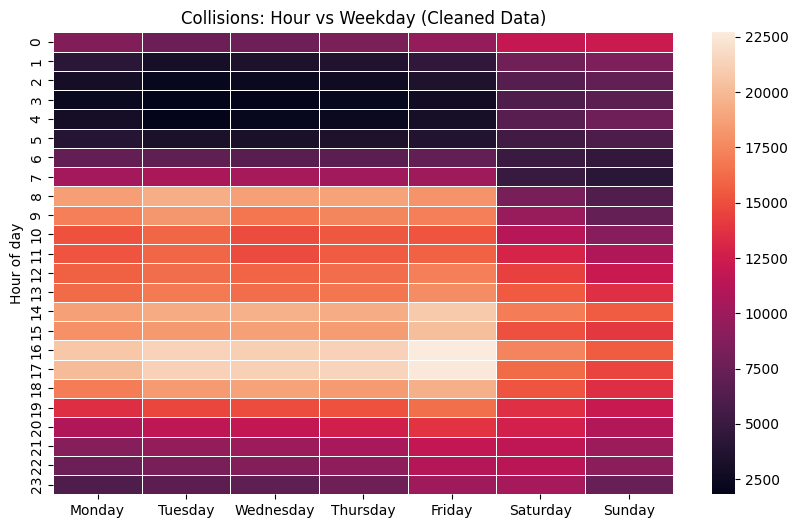

In [66]:

# Hour vs Weekday heatmap (cleaned)
if df_cleaned.empty:
    print('No cleaned data to create heatmap')
else:
    if 'CRASH_DATETIME' in df_cleaned.columns:
        tmp = df_cleaned.dropna(subset=['CRASH_DATETIME']).copy()
        tmp['hour'] = tmp['CRASH_DATETIME'].dt.hour
        weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
        tmp['weekday'] = pd.Categorical(tmp['CRASH_DATETIME'].dt.day_name(), categories=weekday_order, ordered=True)
        pivot = tmp.groupby(['hour','weekday']).size().unstack(fill_value=0).reindex(columns=weekday_order).fillna(0)
        plt.figure(figsize=(10,6))
        sns.heatmap(pivot, cmap='rocket', linewidths=.5)
        plt.title('Collisions: Hour vs Weekday (Cleaned Data)')
        plt.ylabel('Hour of day')
        plt.xlabel('')
        plt.show()
    else:
        print('CRASH_DATETIME not available for heatmap')


In [70]:

# Scatter Mapbox (cleaned) - sample for performance
if df_cleaned.empty:
    print('No cleaned data for map')
else:
    if 'LATITUDE' in df_cleaned.columns and 'LONGITUDE' in df_cleaned.columns:
        m = df_cleaned.dropna(subset=['LATITUDE','LONGITUDE']).sample(n=min(5000, len(df_cleaned)), random_state=1)
        fig = px.scatter_mapbox(m, lat='LATITUDE', lon='LONGITUDE', color=m.get('BOROUGH', None), hover_data=['CRASH_DATETIME','CONTRIBUTING FACTOR VEHICLE 1'], zoom=10, height=600, title='Collision Map (Cleaned Data)')
        fig.update_layout(mapbox_style='open-street-map')
        fig.show()
    else:
        print('No LATITUDE/LONGITUDE columns in cleaned data')


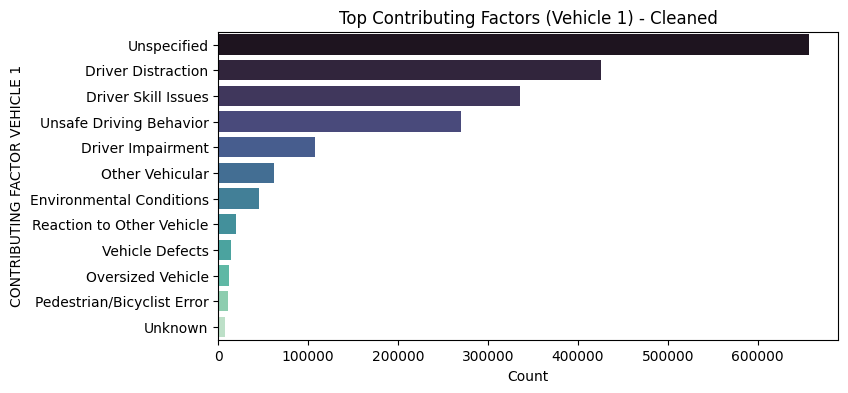

In [71]:

# Top contributing factors (cleaned)
if df_cleaned.empty:
    print('No cleaned data for contributing factors')
else:
    col = 'CONTRIBUTING FACTOR VEHICLE 1'
    if col in df_cleaned.columns:
        top = df_cleaned[col].fillna('Unknown').value_counts().head(12)
        plt.figure(figsize=(8,4))
        sns.barplot(x=top.values, y=top.index, palette='mako')
        plt.title('Top Contributing Factors (Vehicle 1) - Cleaned')
        plt.xlabel('Count')
        plt.show()
    else:
        print(col, 'not found in cleaned data')


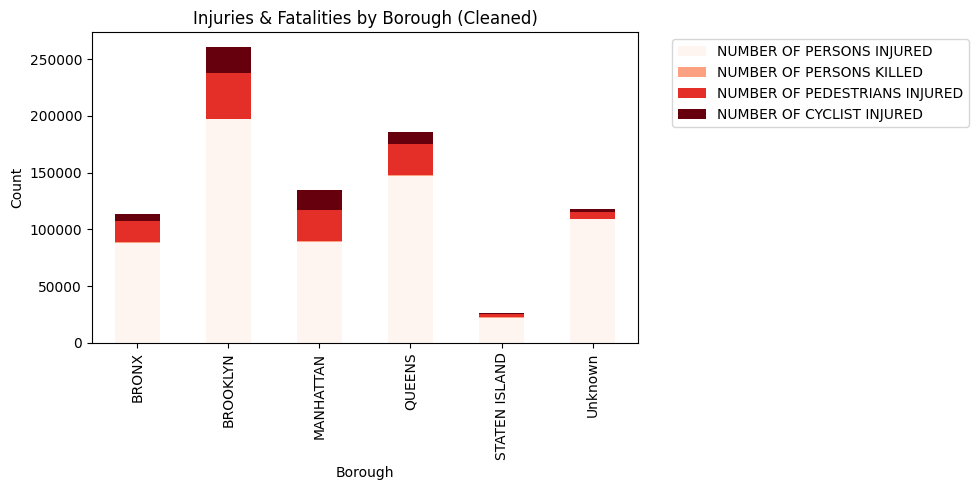

In [72]:

# Injuries & fatalities by borough (cleaned)
if df_cleaned.empty:
    print('No cleaned data for injuries by borough')
else:
    injury_cols = [c for c in ['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUMBER OF PEDESTRIANS INJURED','NUMBER OF CYCLIST INJURED'] if c in df_cleaned.columns]
    if injury_cols and 'BOROUGH' in df_cleaned.columns:
        borough_injuries = df_cleaned.groupby('BOROUGH')[injury_cols].sum().fillna(0)
        borough_injuries.plot(kind='bar', stacked=True, figsize=(10,5), colormap='Reds')
        plt.title('Injuries & Fatalities by Borough (Cleaned)')
        plt.ylabel('Count')
        plt.xlabel('Borough')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print('Required columns not found for injuries by borough')


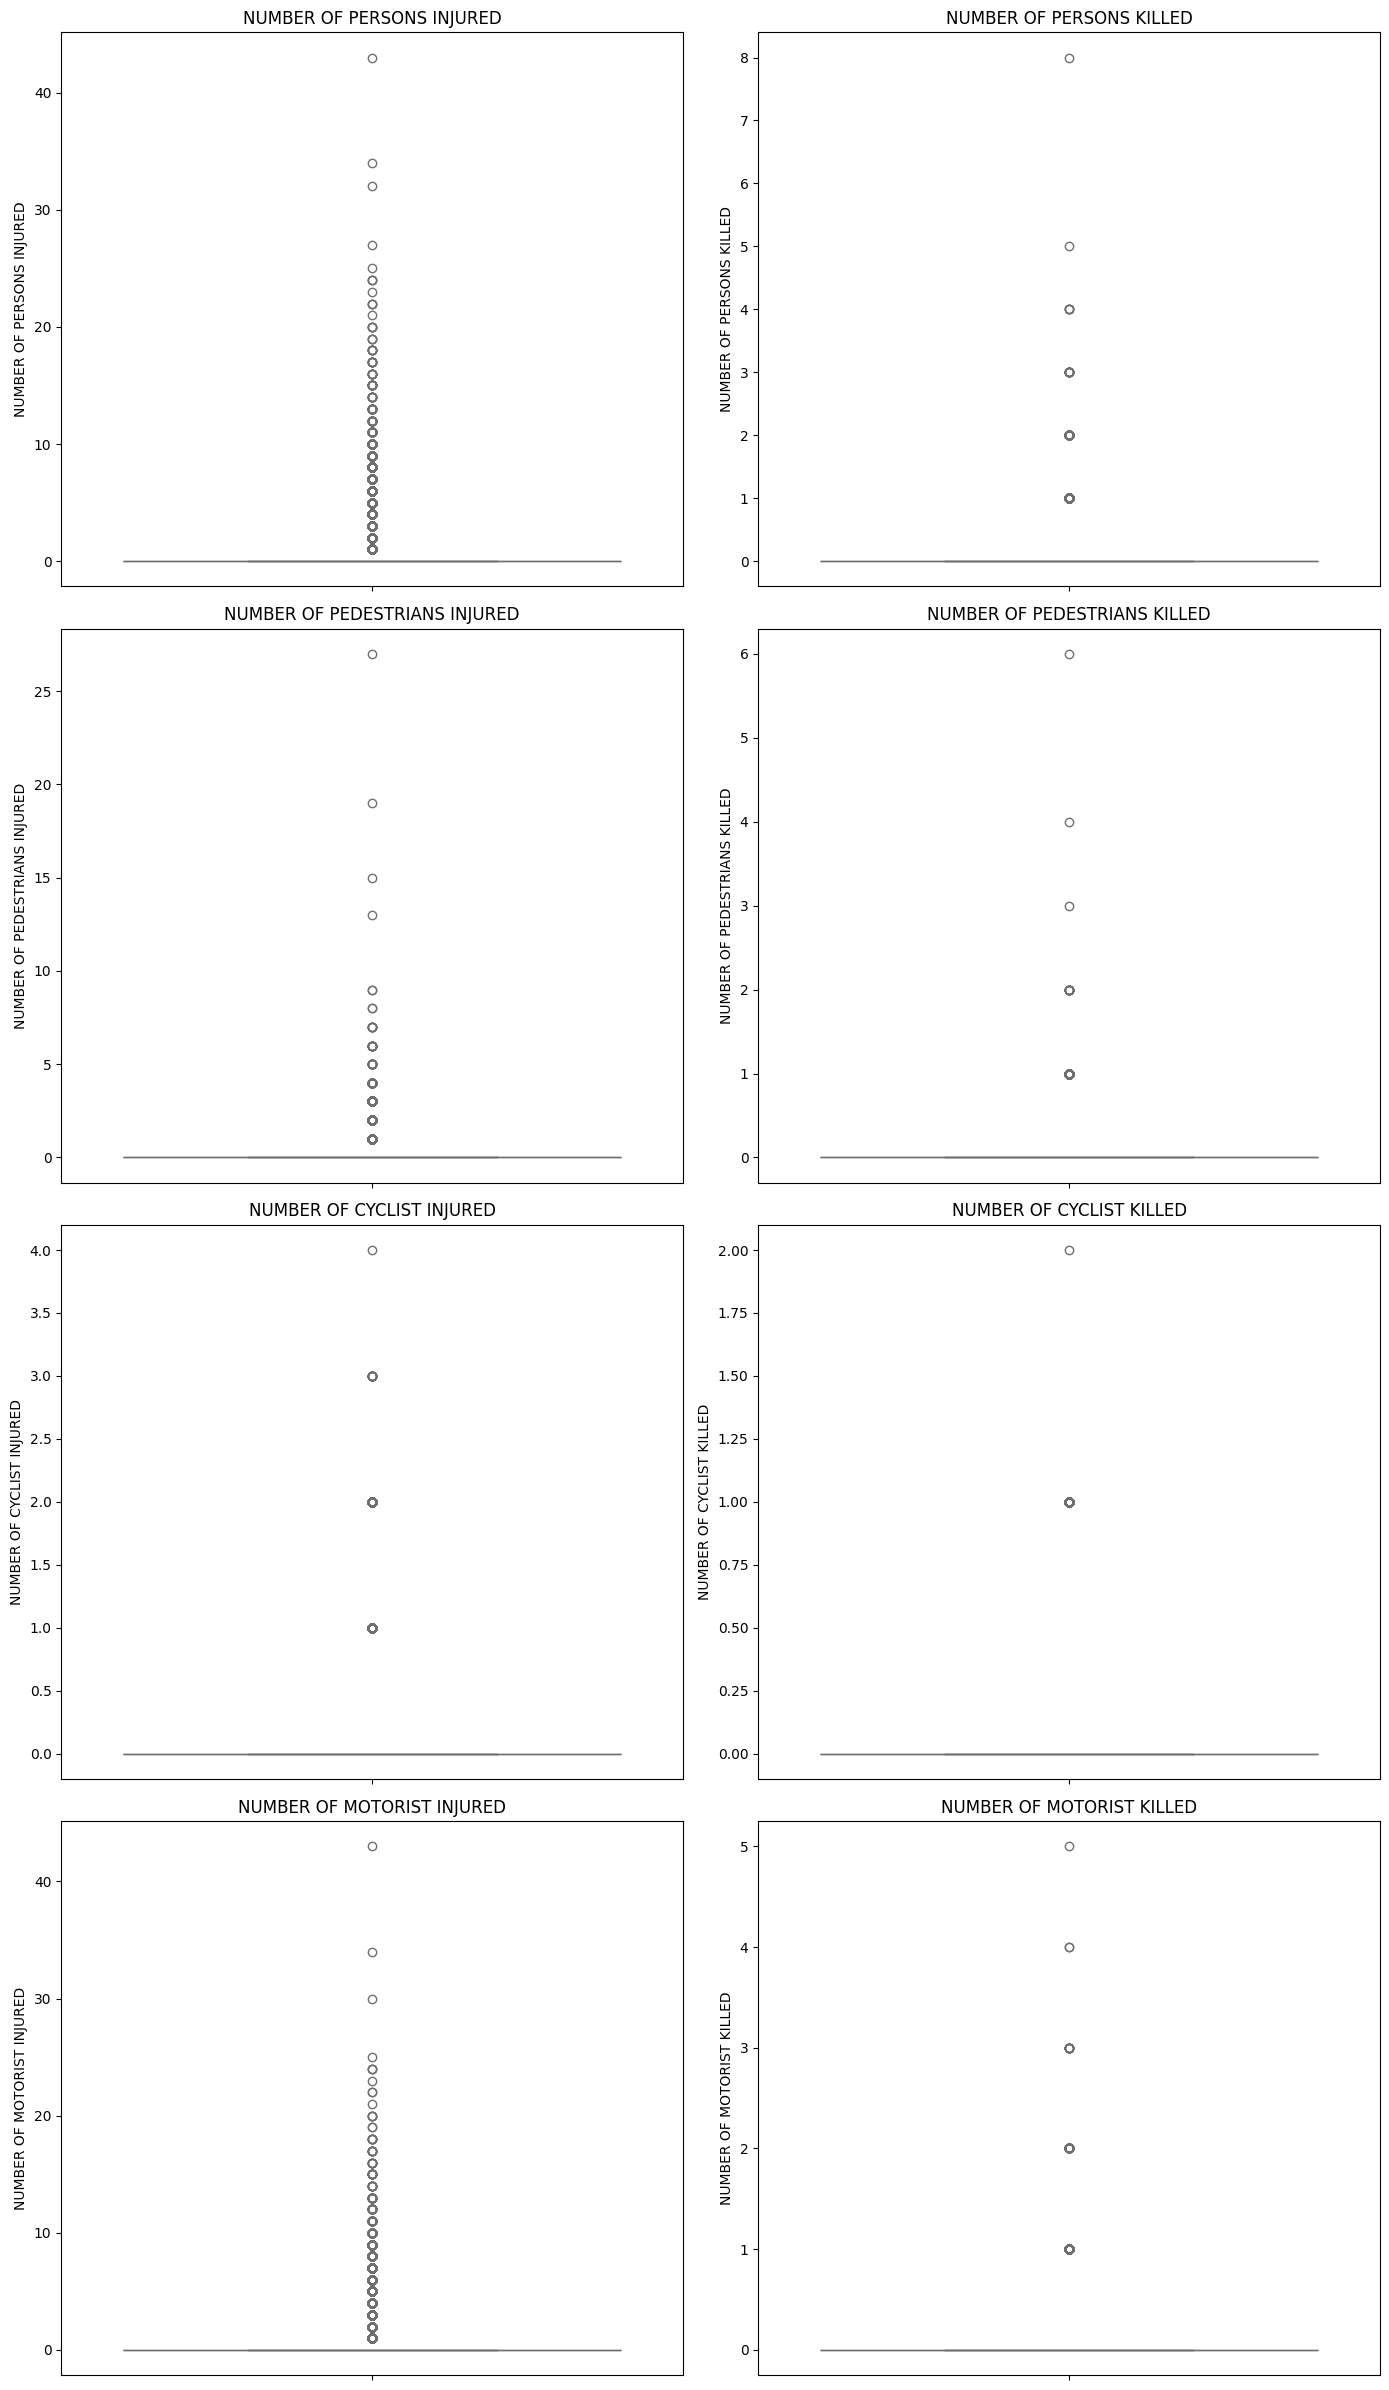

In [73]:

# Boxplots for numeric columns (cleaned)
if df_cleaned.empty:
    print('No cleaned data for boxplots')
else:
    numeric_cols = [c for c in ['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED','NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED'] if c in df_cleaned.columns]
    if numeric_cols:
        fig, axes = plt.subplots(max(1, (len(numeric_cols)+1)//2), 2, figsize=(14, 6*max(1, (len(numeric_cols)+1)//2)))
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        for idx, col in enumerate(numeric_cols):
            sns.boxplot(data=df_cleaned, y=col, ax=axes[idx], color='skyblue')
            axes[idx].set_title(col)
        plt.tight_layout()
        plt.show()
    else:
        print('No numeric injury/fatality columns found in cleaned data')


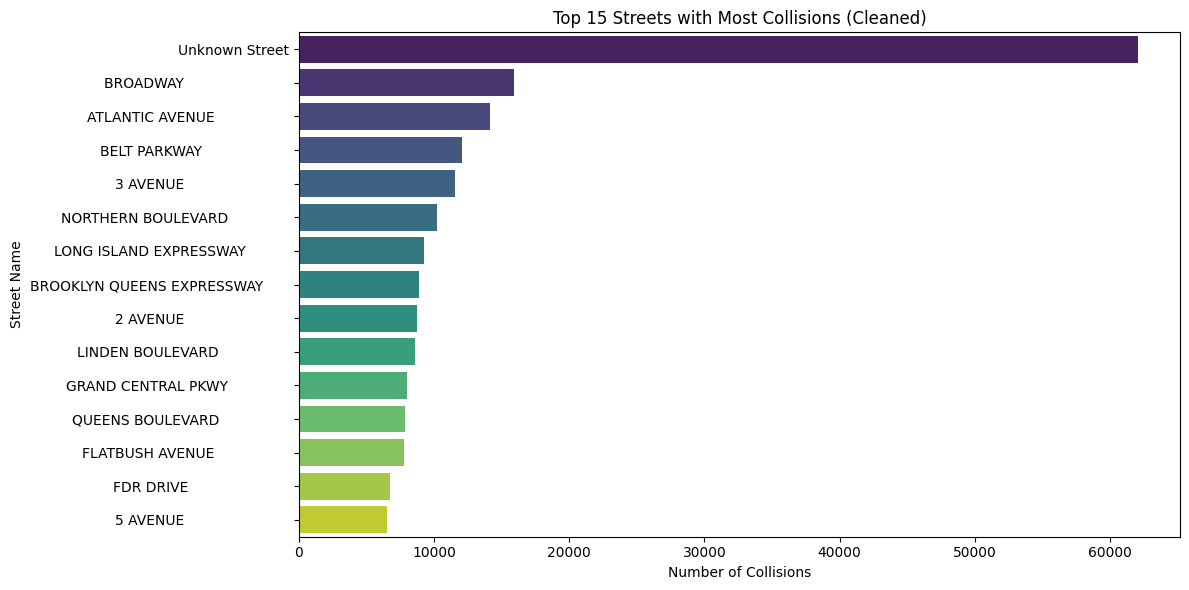

In [74]:

# Top 15 streets (cleaned)
if df_cleaned.empty:
    print('No cleaned data for street analysis')
else:
    if 'ON STREET NAME' in df_cleaned.columns:
        top_streets = df_cleaned['ON STREET NAME'].fillna('Unknown').value_counts().head(15)
        plt.figure(figsize=(12,6))
        sns.barplot(x=top_streets.values, y=top_streets.index, palette='viridis')
        plt.title('Top 15 Streets with Most Collisions (Cleaned)')
        plt.xlabel('Number of Collisions')
        plt.ylabel('Street Name')
        plt.tight_layout()
        plt.show()
    else:
        print('ON STREET NAME not found in cleaned data')


### Post-cleaning visualizations 
The cells above reproduce the main visualizations using the cleaned dataset saved to `data_cleaned/nyc_vehicle_crashes_cleaned.csv`.